# Solving Gerrymandering With a KNN and Gradient Descent Approach
 By John Ziolo

<p>My name is John Ziolo. Over the past month I have developed a possible solution to gerrymandering using a node-based system, and determining the position of these nodes with the AI methods K-Nearest Neighbors (KNN) and Gradient Descent.  Although this model uses some AI techniques, it is based almost entirely on math, to avoid the political factors that lead to gerrymandering. </p>

---

 **What is Gerrymandering?** The Merriam-Webster dictionary defines Gerrymandering as "*The practice of dividing or arranging a territorial unit into election districts in a way that gives one political party an unfair advantage in elections.*"
 <p>“Gerrymandering.” Merriam-Webster.com Dictionary, Merriam-Webster, https://www.merriam-webster.com/dictionary/gerrymandering. Accessed 13 Sep. 2025.<p>
     
---

 **Goal:** The goal for this project is to build a model that can yield an unbiased congressional district map with districts that are more regular in shape, and closer in population to one another.

# Making a Test Model

#### Before we start making real state districts, we need to create a small model that mimics a state.

*  First, we import some necessary libraries.
*  Then, we need a function that generates clusters that look like cities.
*  Finally, we can make the model.

In [39]:
import pandas as pd #Data Frames
import math
import random
import matplotlib.pyplot as plt #What I use for plotting data
import numpy as np #Math on big lists, works with pandas
from PIL import Image #Images to arrays

In [40]:
def generateCitizen(orgX,orgY,maxDis):
    """
    Makes cities by generating clusters of position data
    
    input:
    orgX: int, X value of the city
    orgY: int, Y value of the city
    maxDis: int, The radius of the city

    returns:
    Tuple containing two lists, (list of X values, list of Y values)
    """
    
    dis = random.uniform(-maxDis,maxDis) #Gets a random distance
    perOfDis = random.uniform(0,1)#This will be the percent of the distance we will take. We want the population at the edge of the city to be rare.
    dis = dis * perOfDis
    direction = math.radians(random.randint(0,360)) #Random direction in degrees
    xTemp = orgX + math.cos(direction) * dis
    yTemp = orgY + math.sin(direction) * dis
    #gets the exact coordinates that were randomly generated using sin and cos
    return (round(xTemp),round(yTemp))

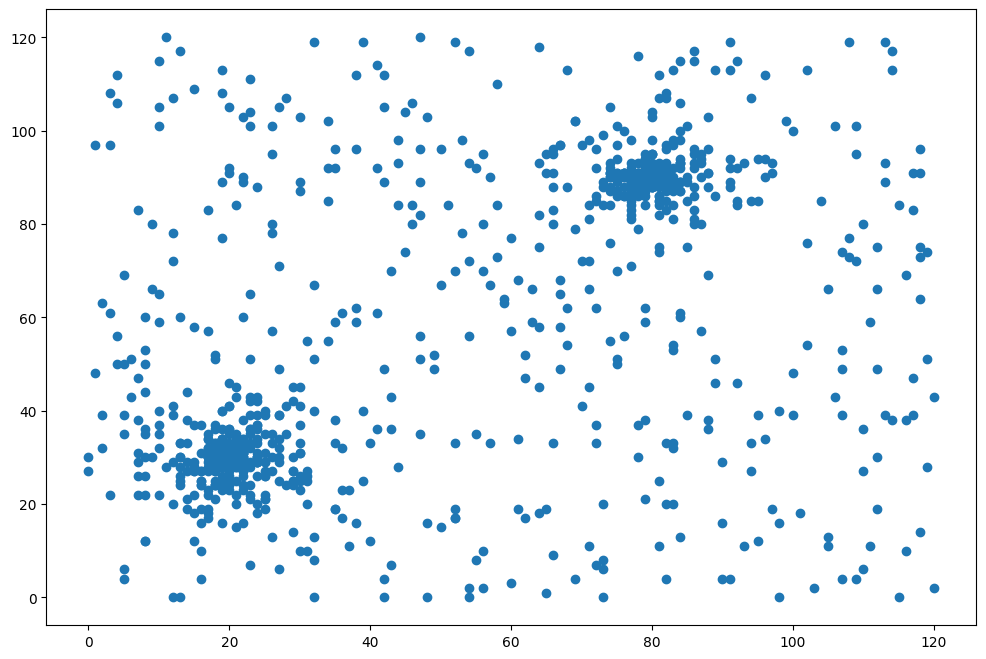

In [41]:
populationMap = pd.DataFrame()

#To facilitate population data, I'll just load the data into lists and pack it all into the DataFrame.
x= []
y= []
#First city is in coordinates (20,80)
#Second city is in coordinates (50, 30)

for i in range(350):#first "city" 350K people
    pos = generateCitizen(20,30,20)
    x.append(pos[0])
    y.append(pos[1])
for i in range(250):#second "city" 250K people
    pos = generateCitizen(80,90,20)
    x.append(pos[0])
    y.append(pos[1])
for i in range(400):#This is rural landscape, less dense but spans the whole state.
    x.append(random.randint(0,120))
    y.append(random.randint(0,120))

#Loading the data...
populationMap["X"] = x
populationMap["Y"] = y
plt.figure(figsize = (12,8))

#ploting
plot = plt.scatter(data = populationMap, x = "X", y = "Y")

#### This is the state of Coloroming, a made up state that we will redistrict.

Every dot is a thousand people, and the position of the dot is where they live.<br>
It has a total population of one million people, two cities, and **three congressional districts**.<br>
In order to district Coloroming, we first use KNN.

# KNN: K - Nearest Neighbors

KNN or K - Nearest Neighbors is a **clustering** algorithm.  KNN takes points of data and seperates then into different groups.<br>
The "K" in KNN is a **number**, the number of clusters.  Here, "K" is the number of **districts**, and to make the districts we will find clusters of population.

#### Let's see it in action.

---

First, all Districts Centers are put in a random position.

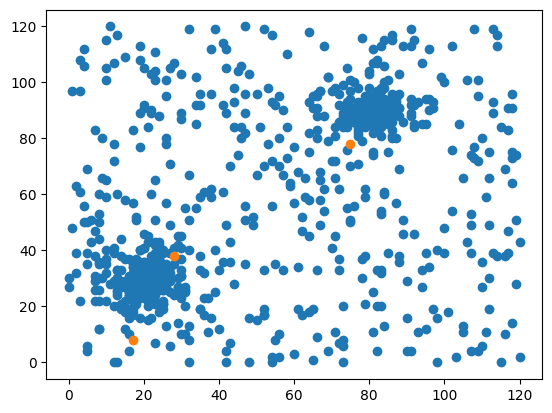

In [42]:
districts = 3 #number of congressional districts

#making the data for the points
districtMap = pd.DataFrame(columns = ("X","Y"))

for i in range(districts):#goes to every district and assigns a random position for it
    districtMap.loc[len(districtMap)] = [random.randint(0,100),random.randint(0,100)]

#graphs it
plt.scatter(data = populationMap, x = "X",y = "Y")
plt.scatter(data = districtMap, x = "X",y = "Y")

The **blue dots** are the **people.** (Every dot is 1000 people). <br>
The **orange dots** are the **District Nodes.** (In a minute they will determine which population points belong to what district.)

---

Then, you assign every point to a district based on Distance.

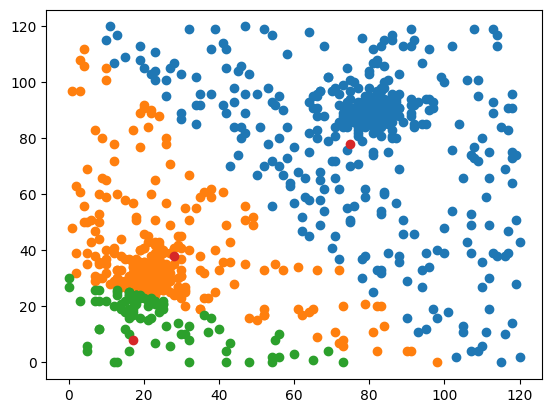

In [43]:
def findDistance(perX,perY,cenX,cenY):
    """
    Finds the distance between two points.
    (There is a built in method for this, but we will be messing with the code a little later, so its better to have it written out right now.)
    
    input: 
    perX: X value of the current point
    perY: Y value of the current point
    cenX: X value of the current district
    cenY: Y value of the current district

    returns:
    double: The distance between the two points.
    """
    return abs(math.sqrt((cenX - perX) ** 2 + (cenY - perY) ** 2))
    
results = [] #will hold the DataFrames of the districts points.

for w in range(len(districtMap)):
    results.append([[],[]]) #the first list will hold "X" the second will hold "Y"
    
for i in range(len(populationMap["X"])):
    pointXVal = populationMap["X"][i]
    pointYVal = populationMap["Y"][i]
    assignedPoint = None
    distance = None
    position = None
    currentPoint = 0
    for e in districtMap.iterrows(): #iterates through all the districts to find the closest one to the current point.  
        #All variables before are to store the closest points information.
        popXVal = e[1]["X"]
        popYVal = e[1]["Y"]
        currDistance = findDistance(pointXVal,pointYVal,popXVal,popYVal)
        if assignedPoint == None:
            assignedPoint = e[0]
            distance = currDistance
            position = pos
        else:
            if currDistance < distance:
                assignedPoint = e[0]
                distance = currDistance
                position = pos
        currentPoint += 1
    #when the closest is obtained, it is added to the results
    results[assignedPoint - 1][0].append(pointXVal)
    results[assignedPoint - 1][1].append(pointYVal)
    
finalResults = [] #Those results are then packed into a DataFrame to show.
for i in results:
    temp = pd.DataFrame()
    temp["X"] = i[0]
    temp["Y"] = i[1]
    finalResults.append(temp)
    #graphing
    plt.scatter(data = temp,x = "X",y = "Y")
plt.scatter(data = districtMap, x = "X",y = "Y")
    

Then the districts change their position to the average position of the points they own.

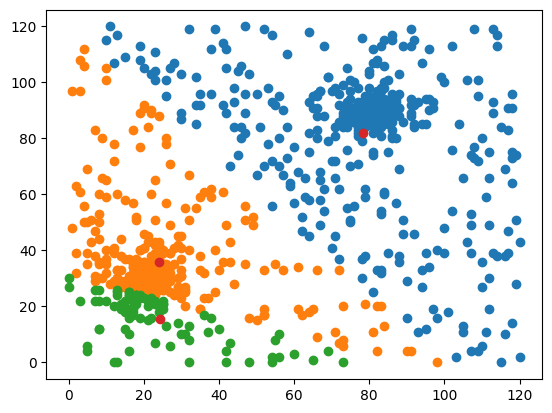

In [44]:
#the mean will be a decimal, so the type must be changed
districtMap["X"] = districtMap["X"].astype('float64')
districtMap["Y"] = districtMap["Y"].astype('float64')

for x,district in enumerate(finalResults):
    #takes the mean of both X and Y. 
    #Then updates the DataFrame
    tempX = np.mean(district["X"])
    tempY = np.mean(district["Y"])
    districtMap.loc[x] = [tempX,tempY]
    plt.scatter(data = district,x = "X",y = "Y")
plt.scatter(data = districtMap,x = "X",y = "Y")

This process is repeated until the dictricts no longer move.

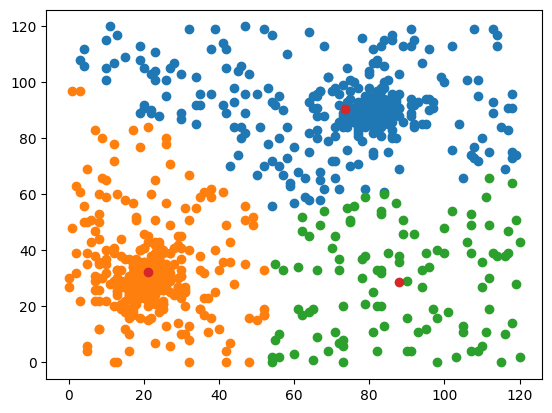

In [45]:
districts = 3

epochs = 10 #how many times the algorithm will be ran

for w in range(epochs):
    mapPoints = []
    for i in range(districts):
        mapPoints.append([[],[]])
    for e in range(len(populationMap["X"])):
        pos = (populationMap["X"][e],populationMap["Y"][e])#position of the current person
        assignedPoint = None
        distance = None
        position = None
        for i in range(districtMap.shape[0]):
            pointPos = (districtMap.loc[i]["X"],districtMap.loc[i]["Y"])#position of the current district node
            currDistance  = findDistance(pointPos[0],pointPos[1],pos[0],pos[1])
            if assignedPoint == None:
                assignedPoint = i
                distance = currDistance
                position = pos
            else:
                if currDistance < distance:
                    assignedPoint = i
                    distance = currDistance
                    position = pos
        #Then the closest point gets added to the map.
        mapPoints[assignedPoint][0].append(position[0])
        mapPoints[assignedPoint][1].append(position[1])
    for i in range(districtMap.shape[0]):#Now we take the mean of all the points
        tempX = np.mean(mapPoints[i][0])
        tempY = np.mean(mapPoints[i][1])
        districtMap.loc[i] = [tempX,tempY]

#Data Visual
for i in mapPoints:
    plt.scatter(x = i[0],y =i[1])
plt.scatter(data = districtMap,x = "X",y = "Y")

See how the dots typically gravitate to the **center** of the Cities?  This is a **Clustering** algorithm, so the dots take over cities, and push each other away as a result.


#### How to read this map:

The colors do not mean anything.  They are there so we can see what people belong to what district.  If you want to, you can make lines between the differently colored dots to make district borders.

The red dots are the center of the district, or the district nodes.  They determine which population points go to which district by taking all the closest dots and claiming them for their district.

---

Now we have districts, but these districts are unacceptable.
In America, when making congressional districts there is an emphasis on **every vote being equal in value**. <br>
Because every district is one vote, every district must be as close to each other in population as possible.  

District 1: 427K people
District 2: 464K people
District 3: 109K people


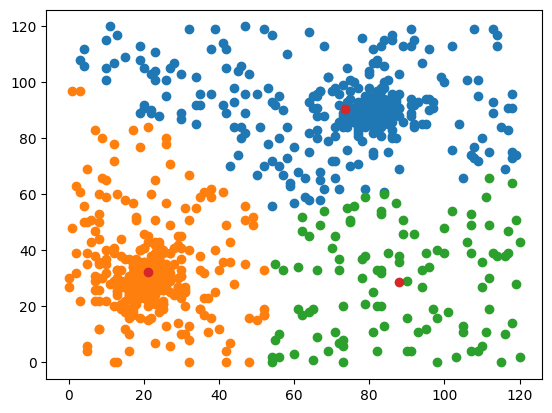

In [46]:
for x,i in enumerate(mapPoints):
    print("District " + str(x+1) + ": " + str(len(i[0])) + "K people")
    plt.scatter(x = i[0],y =i[1])
plt.scatter(data = districtMap,x = "X",y = "Y")

It's safe to say that KNN alone will not create acceptable congressional districts.  This is mostly because KNN makes the nodes compete for the data, and the first node that lands on the biggest city will "own" the points, and drive other codes away.  
<br>What happened here, is the first two nodes claim the two cities, and stay in the middle of their city.  The last one is then driven away from the cities, and claims as much rural landscape as possible, causing population inequality.

<br>A solution to this problem is **Gradient Descent**, an AI algorithm that makes small changes to its weights, and sees if the result improved. If it improved, the weight will continue in that direction until the result gets worse.

---

#  Cost Function / Gradient Descent

This next step uses two main functions:

### 1.  Cost Function:
Cost = $\frac{1}{m}$ * $Σ^{n}_{i=0}$($f(x)^{(i)} - y^{i})^{2}$

Let's break it down:

$\frac{1}{m}$ = Multiplied to the function to recive the average cost (or error) of the results collectivly.

$Σ^{n}_{i=0}$ = Iterates through all the test cases, or in our case, citizens.

$f(x)^{(i)}$ = What your AI returns for the given test case.

$y^{i}$ = The optimal or correct answer for the given the given test case.

In simple terms, the Cost function goes through every test case, and squares how far off the test case was, then gets the average of all the errors.

**Cost measures the error in any state the AI is in**.

---

### 2. Gradient Decsent:

𝜃 = 𝜃 - (a * ΔCost)

Let's break it down:

𝜃 = The current weight of the AI thats being changed

a = learn rate, says how much the weight is being changed

ΔCost = change in Cost, this takes the output from the cost function and sees which direction to move the weight.
> Note: "=" doesn't mean "equal to" here. 𝜃 is being set to the value on the right side of the function.

This function takes a weight, moves it around in all directions, sees which direction has the lowest error, and changes the weight in that direction.

**Gradient Descent takes the Cost function, and constantly checks which way the AI should move to be a better model.**

---

### Here's an example of the Cost Function at work:

As an example, let's say we had a linear equation, and the AI took guesses at where the line would be, with some error.

We will create correct values, and make fake AI responses and calulate the Cost of it.
For each correct answer, there is an AI answer.  The distance bwteen the right answer (f(x) - y) is were we get our cost.



Text(0.5, 1.0, 'Cost: 0.33')

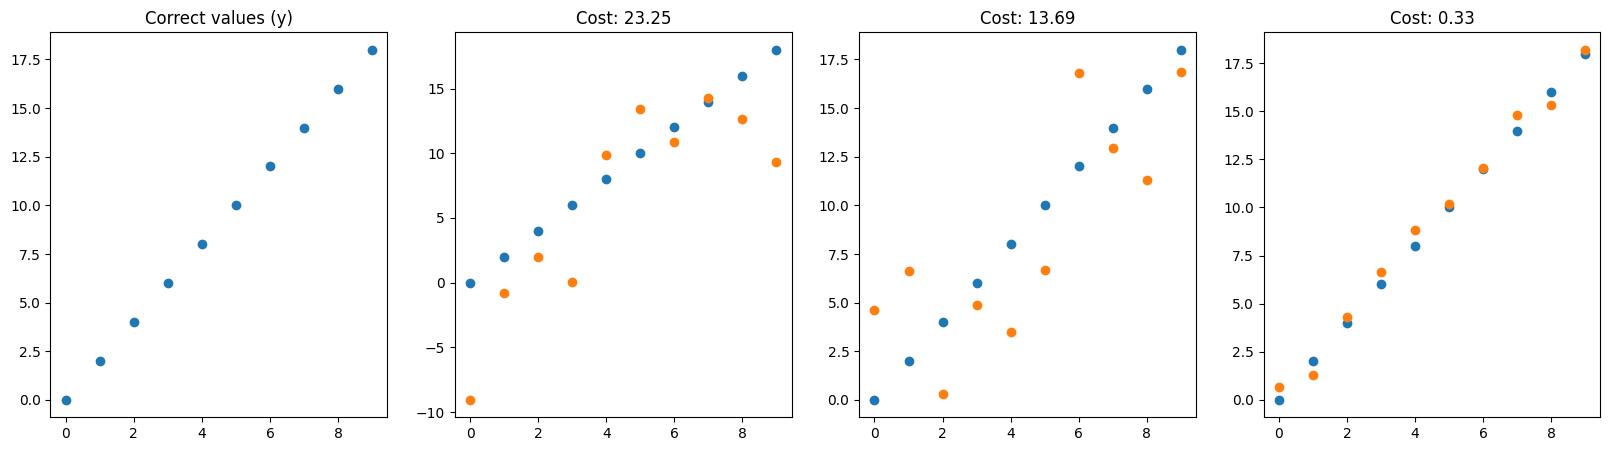

In [47]:
print("We will create correct values, and make fake AI responses and calulate the Cost of it.")
print("For each correct answer, there is an AI answer.  The distance bwteen the right answer (f(x) - y) is were we get our cost.\n")

AI1List = pd.DataFrame(columns = ("X","Y"))#This will be the response with the most error
AI2List = pd.DataFrame(columns = ("X","Y"))#This will be the response with the middle error
AI3List = pd.DataFrame(columns = ("X","Y"))#This will be the response with the least error
YList = pd.DataFrame(columns = ("X","Y"))#This will be the correct answer.

def findCost(YList,AIList):#This will run the cost function.
    totalCost = 0#this variable will store the total cost
    m = AIList.shape[0]
    for i in range(m):#Goes through all the x values, gets the error of them, then adds the squared value to the total
        fOfx = AIList.loc[i]["Y"]
        y = YList.loc[i]["Y"]
        totalCost += (fOfx -y) ** 2
    avgCost = totalCost / m #divides the cost by the number of x values
    return round(avgCost * 100)/100

#Gets our "Results"
for i in range(10):
    YList.loc[len(YList)] = [i,i * 2]
    AI1List.loc[len(AI1List)] = [i,i * 2 + random.uniform(-10,10)]#most cost
    AI2List.loc[len(AI2List)] = [i,i * 2 + random.uniform(-5,5)]#middle cost
    AI3List.loc[len(AI3List)] = [i,i * 2 + random.uniform(-1,1)]#least cost
    
YList.set_index("X",inplace = True)
AI1List.set_index("X",inplace = True)
AI2List.set_index("X",inplace = True)
AI3List.set_index("X",inplace = True)


#Visualize the Data
fig,ax = plt.subplots(1,4,figsize = (20,5))
ax[0].scatter(data = YList.reset_index(),x = "X",y = "Y")
ax[0].set_title("Correct values (y)")

ax[1].scatter(data = YList.reset_index(),x = "X",y = "Y")
ax[1].scatter(data = AI1List.reset_index(),x = "X",y = "Y")
ax[1].set_title("Cost: " + str(findCost(YList,AI1List)))

ax[2].scatter(data = YList.reset_index(),x = "X",y = "Y")
ax[2].scatter(data = AI2List.reset_index(),x = "X",y = "Y")
ax[2].set_title("Cost: " + str(findCost(YList,AI2List)))

ax[3].scatter(data = YList.reset_index(),x = "X",y = "Y")
ax[3].scatter(data = AI3List.reset_index(),x = "X",y = "Y")
ax[3].set_title("Cost: " + str(findCost(YList,AI3List)))

Notice how the further the **orange dots** (AI Responses) are from the **blue dots** (Correct Responses) the higher the **Cost** is.

---

### Here's an example of Gradient Descent at work: 

Let's say that there is an AI that needs to find out the values of a linear function.  The AI can compare itself to the correct responses, and it has two "weights".

1. x: slope 

2. b: intercept

These two weights are numbers that will be put in the classic linear function.  
<br>
y = mx + b
<br>
The AI's weights will be compared to the correct linear slope: 
<br>
y = **4**x + **-8** 
<br>
And the further **it's linear line** gets from the **correct linear line**, the more **cost** the AI will get.

### Watch how **Gradient Descent** uses **Cost** to yield the correct linear slope:


Here, we are going to make the orange line (AI) try to match the blue line (correct line) without telling the AI the parameters. (slope and intercept)


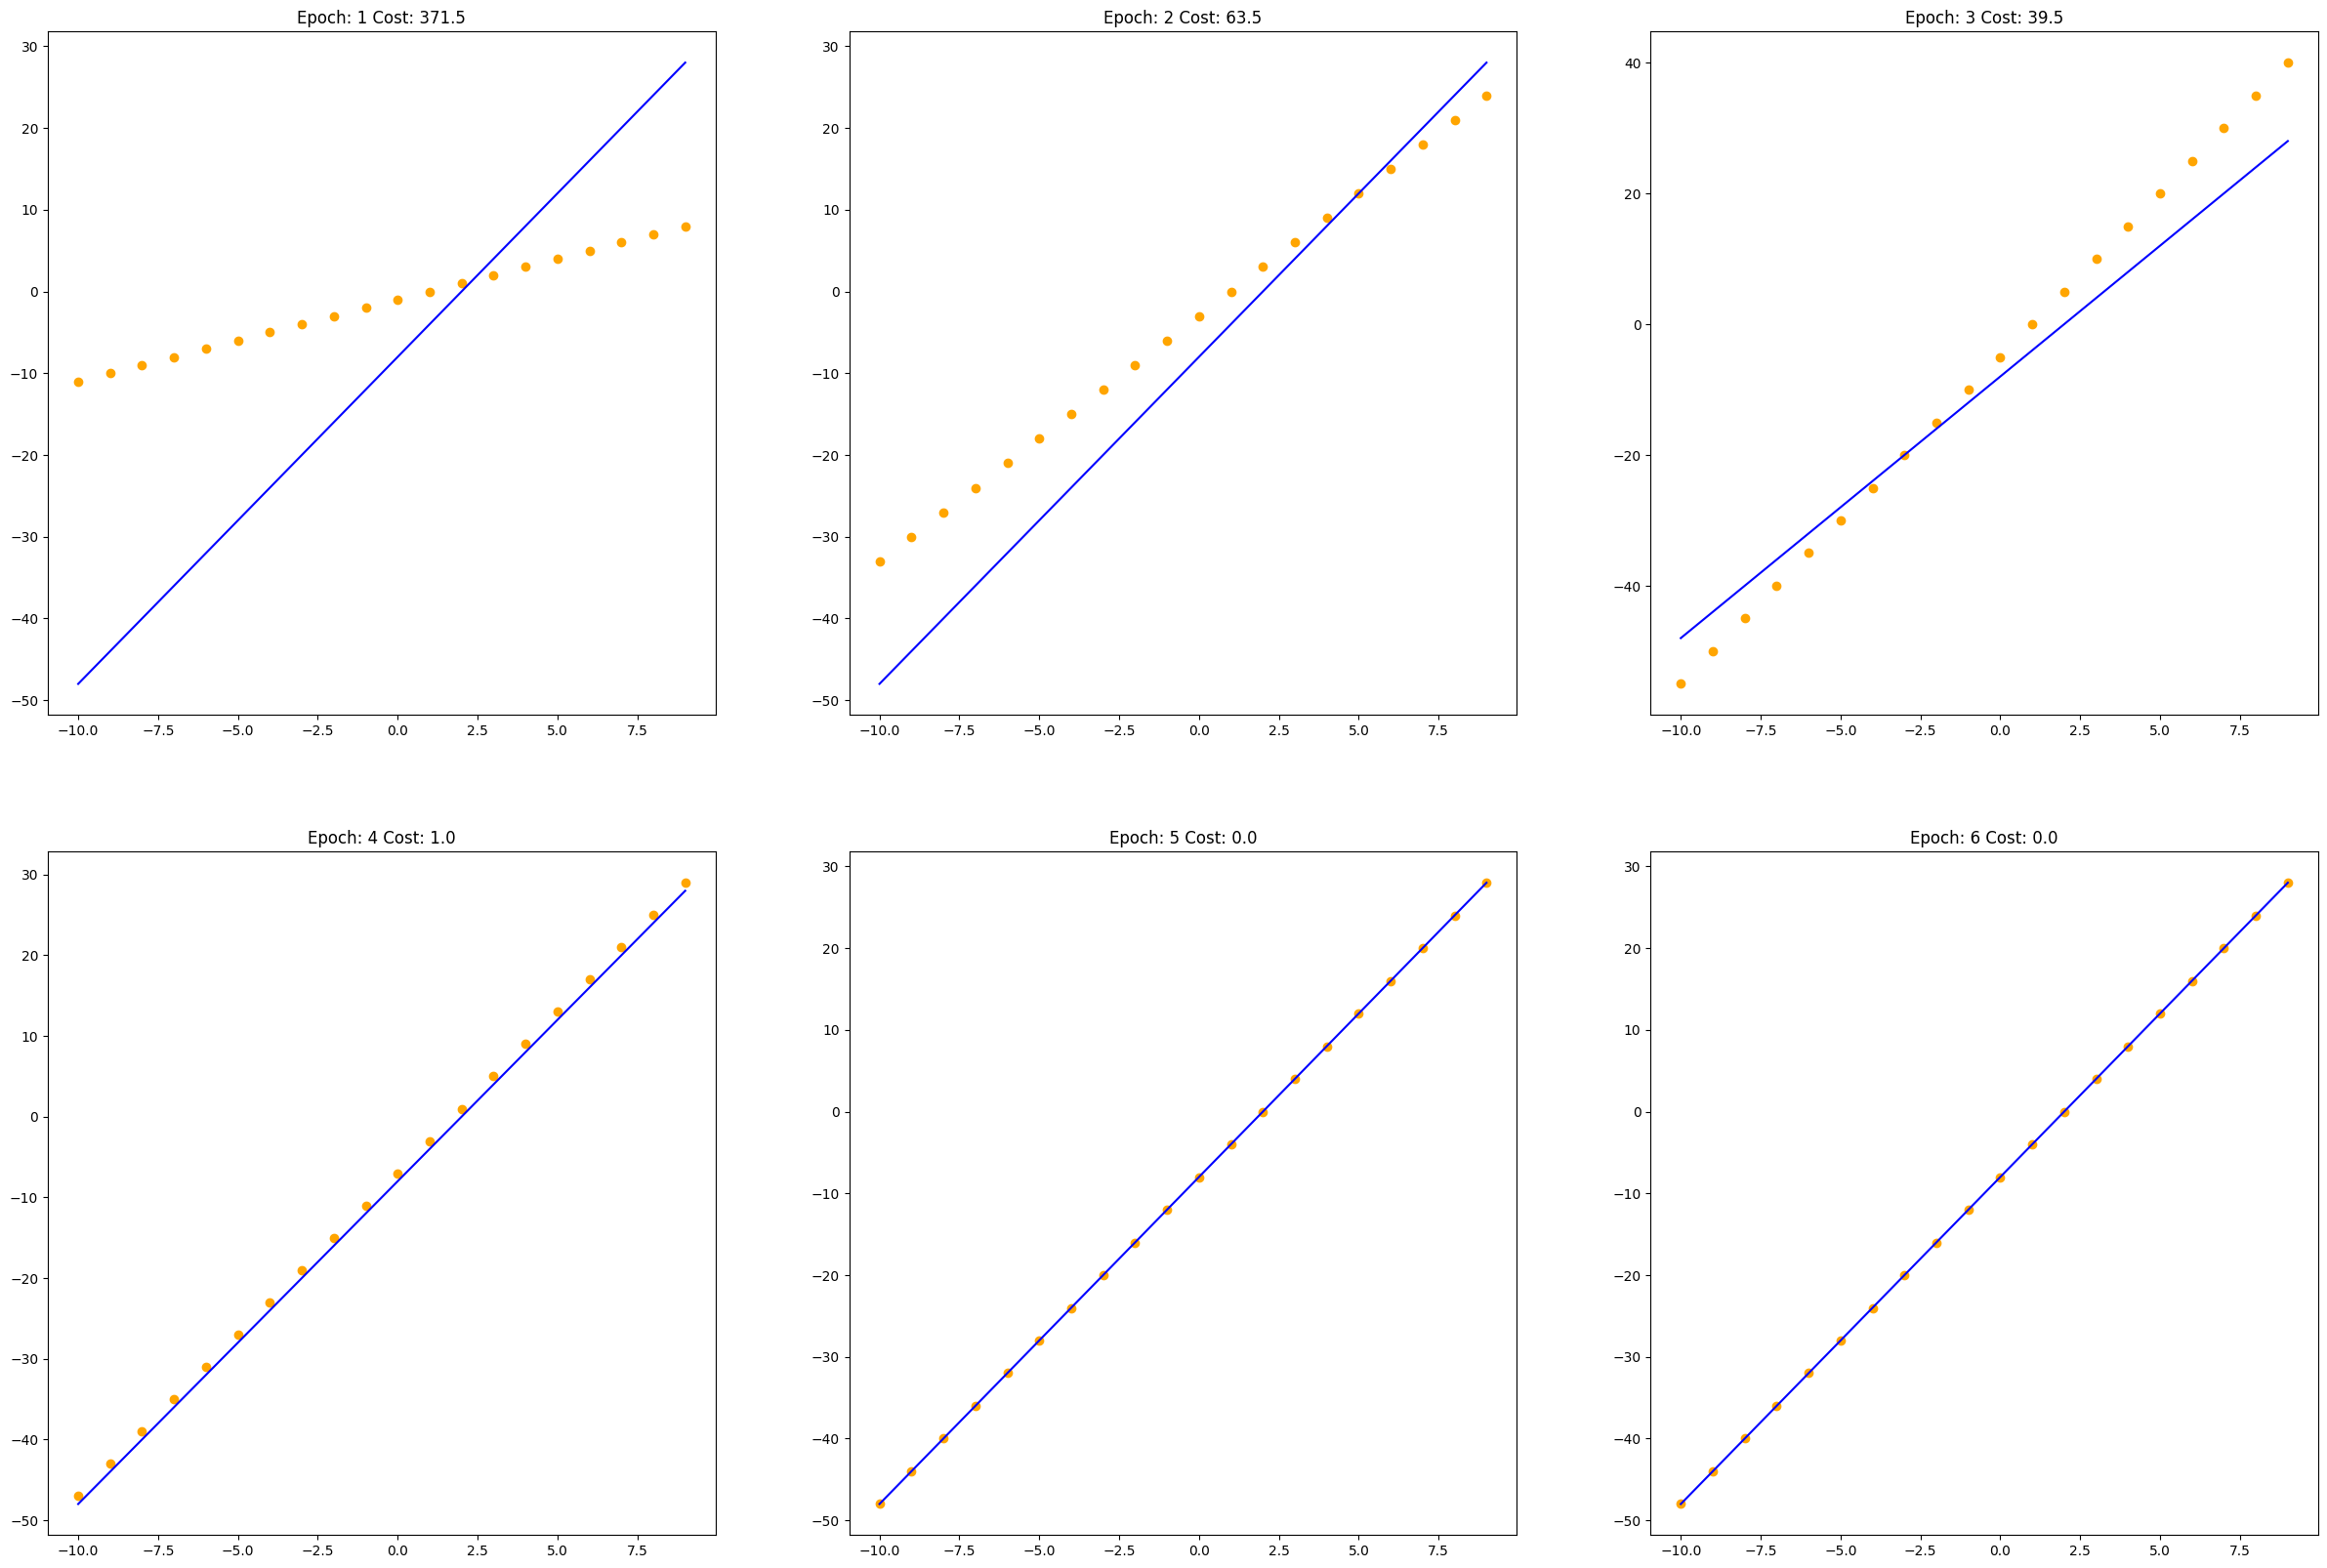

In [48]:
def computeCost(Y, AIY):#Same thing as earlier
    total = 0
    for i in range(Y.shape[0]):
        fOfx = AIY.loc[i]["Y"]
        y = Y.loc[i]["Y"]
        total += (fOfx - y) ** 2
    avgCost=  total / Y.shape[0]
    return avgCost
    
def recompute(AISlope,AIIntercept):#Turns 0-20 graphs to -10 - 10 graphs, because 0-20 doesnt work, needs more coding.
    AIList = pd.DataFrame(columns = ("X","Y"))
    for e in range(20):
        AIList.loc[len(AIList)] = [e-10,AISlope * (e-10) + AIIntercept]
    return AIList

#Vvisualization
fig, ax = plt.subplots(2,3,figsize = (30,20))
plotOrder = [(0,0),(0,1),(0,2),(1,0),(1,1),(1,2)]

#Sets the weights
correctSlope = 4
correctIntercept = -8
YList = pd.DataFrame(columns = ("X","Y"))
for i in range(20):
    YList.loc[len(YList)] = [i-10,correctSlope * (i-10) + correctIntercept]
AISlope = 0
AIIntercept = 0

for i in range(12):#12 epochs, it gets closer to the right answer 12 times.
    changeAISlope = 0
    changeAIIntercept = 0
    currCost = computeCost(YList,recompute(AISlope,AIIntercept))#this is the cost of the current state
    addCost = computeCost(YList,recompute(AISlope + .1, AIIntercept))#this is the cost of the current state with the slope added a little
    subCost = computeCost(YList,recompute(AISlope - .1, AIIntercept))#this is the cost of the current state with the slope substracted a little

    #notice how while going through the different weights, the changes aren't made right after we figure out which direction to go,
    #instead we do all the changes at the end of the epochs.
    if(min([currCost,addCost,subCost]) == addCost):
        changeAISlope += 1
    elif(min([currCost,addCost,subCost]) == subCost):
        changeAISlope -= 1
    currCost = computeCost(YList,recompute(AISlope,AIIntercept))#this is the cost of the current state
    addCost = computeCost(YList,recompute(AISlope, AIIntercept + .1))#this is the cost of the current state with the y - intercept added a little
    subCost = computeCost(YList,recompute(AISlope, AIIntercept - .1))#this is the cost of the current state with the y - intercept substracted a little
    if(min([currCost,addCost,subCost]) == subCost):
        changeAIIntercept -= 1
    elif(min([currCost,addCost,subCost]) == addCost):
        changeAIIntercept += 1

    #add the changes to the current state
    AISlope += changeAISlope
    AIIntercept += changeAIIntercept

    #save the data for later visualization
    if(i % 2 == 0):
        curr = recompute(AISlope, AIIntercept)
        ax[plotOrder[int(i/2)]].scatter(curr["X"],curr["Y"],color = "orange")
        ax[plotOrder[int(i/2)]].plot(YList["X"],YList["Y"],color = "blue")
        ax[plotOrder[int(i/2)]].set_title("Epoch: " + str(i//2 + 1) + " Cost: " + str(computeCost(YList,curr)))
print("Here, we are going to make the orange line (AI) try to match the blue line (correct line) without telling the AI the parameters. (slope and intercept)")

See how the **orange dotted line** gets closer to the **blue line** with every epoch.

---

Recap: The Gradient Descent Function works with the Cost Function to get the error of the model, and constantly uses it to see if the model is moving in the right direction.<br>
This is not traditional Gradient Descent, but it is closer to how we will be using it.


# The Congressional District Standard
In 1973, the United States of America made a court decision on gerrymandering, and it defined a specific way to judge if congressional districts are acceptable or not.

This decision was called **"Gaffney v. Cummings"**.
#### "Minor deviations from mathematical equality among state legislative districts do not make out a prima facie case of invidious discrimination under the Equal Protection Clause of the Fourteenth Amendment, and in this case, where the House districts deviated on the average by 1.9% and the maximum deviation was 7.83%, a prima facie case was not made out"

Gaffney v. Cummings. 412 U.S. 735. Supreme Court, 1973. Library of Congress, https://tile.loc.gov/storage-services/service/ll/usrep/usrep412/usrep412735/usrep412735.pdf. Accessed 6 Sept. 2025.


#### This states that the average deviation is 1.9%, and the maximum deviation possible is 7.83%

Here is how error can be calculated: <br>

#### $\frac{Current District Population - Optimal District Population}{Optimal District Population}$ * 100%

This means to be acceptable, this AI needs to yield **7.83%** error or less, and to be competitive, it needs to yield **1.9%** error or less.

Let's see our error:

The target population is 333K people.
District 1: 427K people, with an error of: 28.23%
District 2: 464K people, with an error of: 39.34%
District 3: 109K people, with an error of: -67.27%


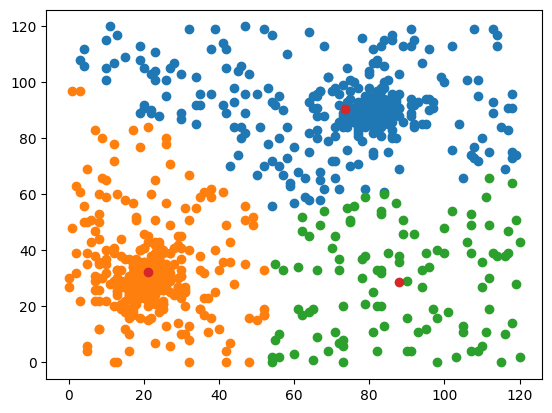

In [49]:
optimalPopulation  = round(populationMap.shape[0] / districtMap.shape[0])

print("The target population is " + str(optimalPopulation) + "K people.")
for x,i in enumerate(mapPoints):
    err = round(((len(i[0]) - optimalPopulation)/optimalPopulation) * 10000)/100
    print("District " + str(x+1) + ": " + str(len(i[0])) + "K people, with an error of: " + str(err) + "%")
    plt.scatter(x = i[0],y =i[1])
plt.scatter(data = districtMap,x = "X",y = "Y")

See how the two **city districts** have way more population than the **rural district**?

In order to make fairer districts, we need to get the points to share city population.

---

# Implimenting Gradient Descent

**Functions**: Most of this we have seen, some are new.

1. **reComputePop**:  Divides the population into the nodes.

2. **findCost**: Takes the result from reComputePop and runs the Cost Function on it to get the error.

3. **showState**: This does not change how the Descent works, it just prints and graphs the current data.

In [50]:
def findDistance(perX,perY,cenX,cenY):
    return abs(math.sqrt((cenX - perX) ** 2 + (cenY - perY) ** 2))#distance again
    return None   
def reComputePop(populationMap,centerPos):
    """
    populationMap : DataFrame [X,Y]
    centerPos : DataFrame [X,Y,weights]

    returns: list of DataFrames[X,Y]
    each DataFrame is full of what the node owns.
    """
    results = [] #this is where the assigned nodes will go
    for w in range(len(centerPos)):
        results.append([[],[]])#the first list will hold "X" the second will hold "Y"
    for i in range(len(populationMap["X"])):
        pointXVal = populationMap["X"][i]
        pointYVal = populationMap["Y"][i]
        assignedPoint = None
        distance = None
        position = None
        currentPoint = 0
        for e in centerPos.iterrows(): #iterates through all the districts to find the closest one to the current point.  
            #All variables before are to store the closest points information.
            popXVal = e[1]["X"]
            popYVal = e[1]["Y"]
            popWeightVal = e[1]["weights"]
            currDistance = findDistance(pointXVal,pointYVal,popXVal,popYVal) * popWeightVal
            if assignedPoint == None:
                assignedPoint = e[0]
                distance = currDistance
                position = pos
            else:
                if currDistance < distance:
                    assignedPoint = e[0]
                    distance = currDistance
                    position = pos
            currentPoint += 1
        #when the closest is obtained, it is added to the results
        results[assignedPoint -1][0].append(pointXVal)
        results[assignedPoint - 1][1].append(pointYVal)
    finalResults = []#Those results are then packed into a DataFrame to show.
    for i in results:
        temp = pd.DataFrame()
        temp["X"] = i[0]
        temp["Y"] = i[1]
        finalResults.append(temp)
    return finalResults
def findCost(populationMap,perfectPop):#runs the cost function
    """
    takes:  
    list of DataFrames
    int ideal district population

    returns: 
    int
    """
    ans = 0
    for i in populationMap:
        if i.shape[0] - perfectPop < 0:
            ans += (perfectPop - i.shape[0]) *2
        else:
            ans += i.shape[0] - perfectPop
    return ans
    
def showState(totalPop, nodes,currentState,perfectPop):#visualization
    plt.scatter(data = totalPop,x = "X",y ="Y",color = "black")
    for i in currentState:
        plt.scatter(data = i,x = "X",y = "Y")
    plt.scatter(data=  nodes, x = "X",y = "Y", color = "grey")
    print("cost: " + str(findCost(currentState,perfectPop)))

#### Additions:

Before we begin gradient descent, we need to add a variable called "weights." 

This variable will change how much a node will attract, above other nodes, by being multiplied to the distance when assigning population.

A weight of less than one means the node will attract farther points, and more than one will make the node attract less population.

#### Demonstration:

Text(0.5, 1.0, 'North District Weighted .7')

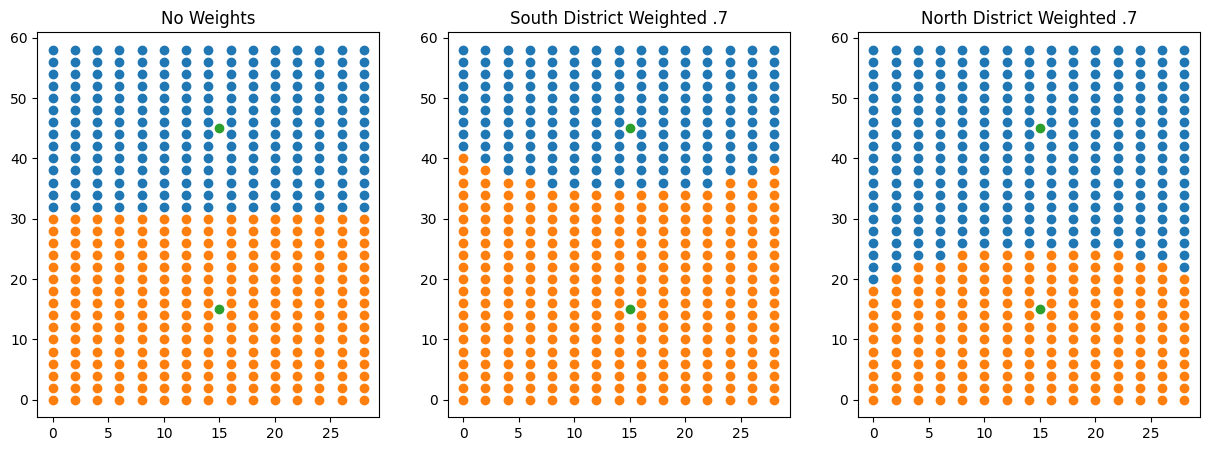

In [51]:
weightExample = pd.DataFrame(columns = ("X","Y"))#this will set up the grid
nodeExample = pd.DataFrame({"X":[15,15],"Y":[15,45],"weights":[1,1]})#this will be the two district nodes.

#sets up the grid
for x in range(15):
    for y in range(30):
        weightExample.loc[len(weightExample)] = [x*2,y*2]

#Visualization
fig, ax = plt.subplots(1,3,figsize = (15,5))

results = reComputePop(weightExample,nodeExample)#no weights
for i in results:
    ax[0].scatter(data = i,x = "X",y = "Y")
ax[0].scatter(data= nodeExample,x = "X",y = "Y")
ax[0].set_title("No Weights")

nodeExample["weights"] = [.7,1.3]#resets the weights to favor the orange district
results = reComputePop(weightExample,nodeExample)
for i in results:
    ax[1].scatter(data = i,x = "X",y = "Y")
ax[1].scatter(data= nodeExample,x = "X",y = "Y")
ax[1].set_title("South District Weighted .7")

nodeExample["weights"] = [1.3,.7]#resets the weights to favor the blue district
results = reComputePop(weightExample,nodeExample)
for i in results:
    ax[2].scatter(data = i,x = "X",y = "Y")
ax[2].scatter(data= nodeExample,x = "X",y = "Y")
ax[2].set_title("North District Weighted .7")

Notice how the weighted graphs form **Curved** boundaries?

---


#### And now we run the AI.
(This can take awhile)

Epoch:100
Learn Rate: 0.078125
Position and Weights:
           X           Y   weights
0  85.124561  112.241657  1.051562
1  -3.885776   57.301724  1.011426
2  52.807339   53.871560  0.976074

Current Cost: 4.0

District 1: 332K people, with an error of: -0.3%
District 2: 334K people, with an error of: 0.3%
District 3: 334K people, with an error of: 0.3%


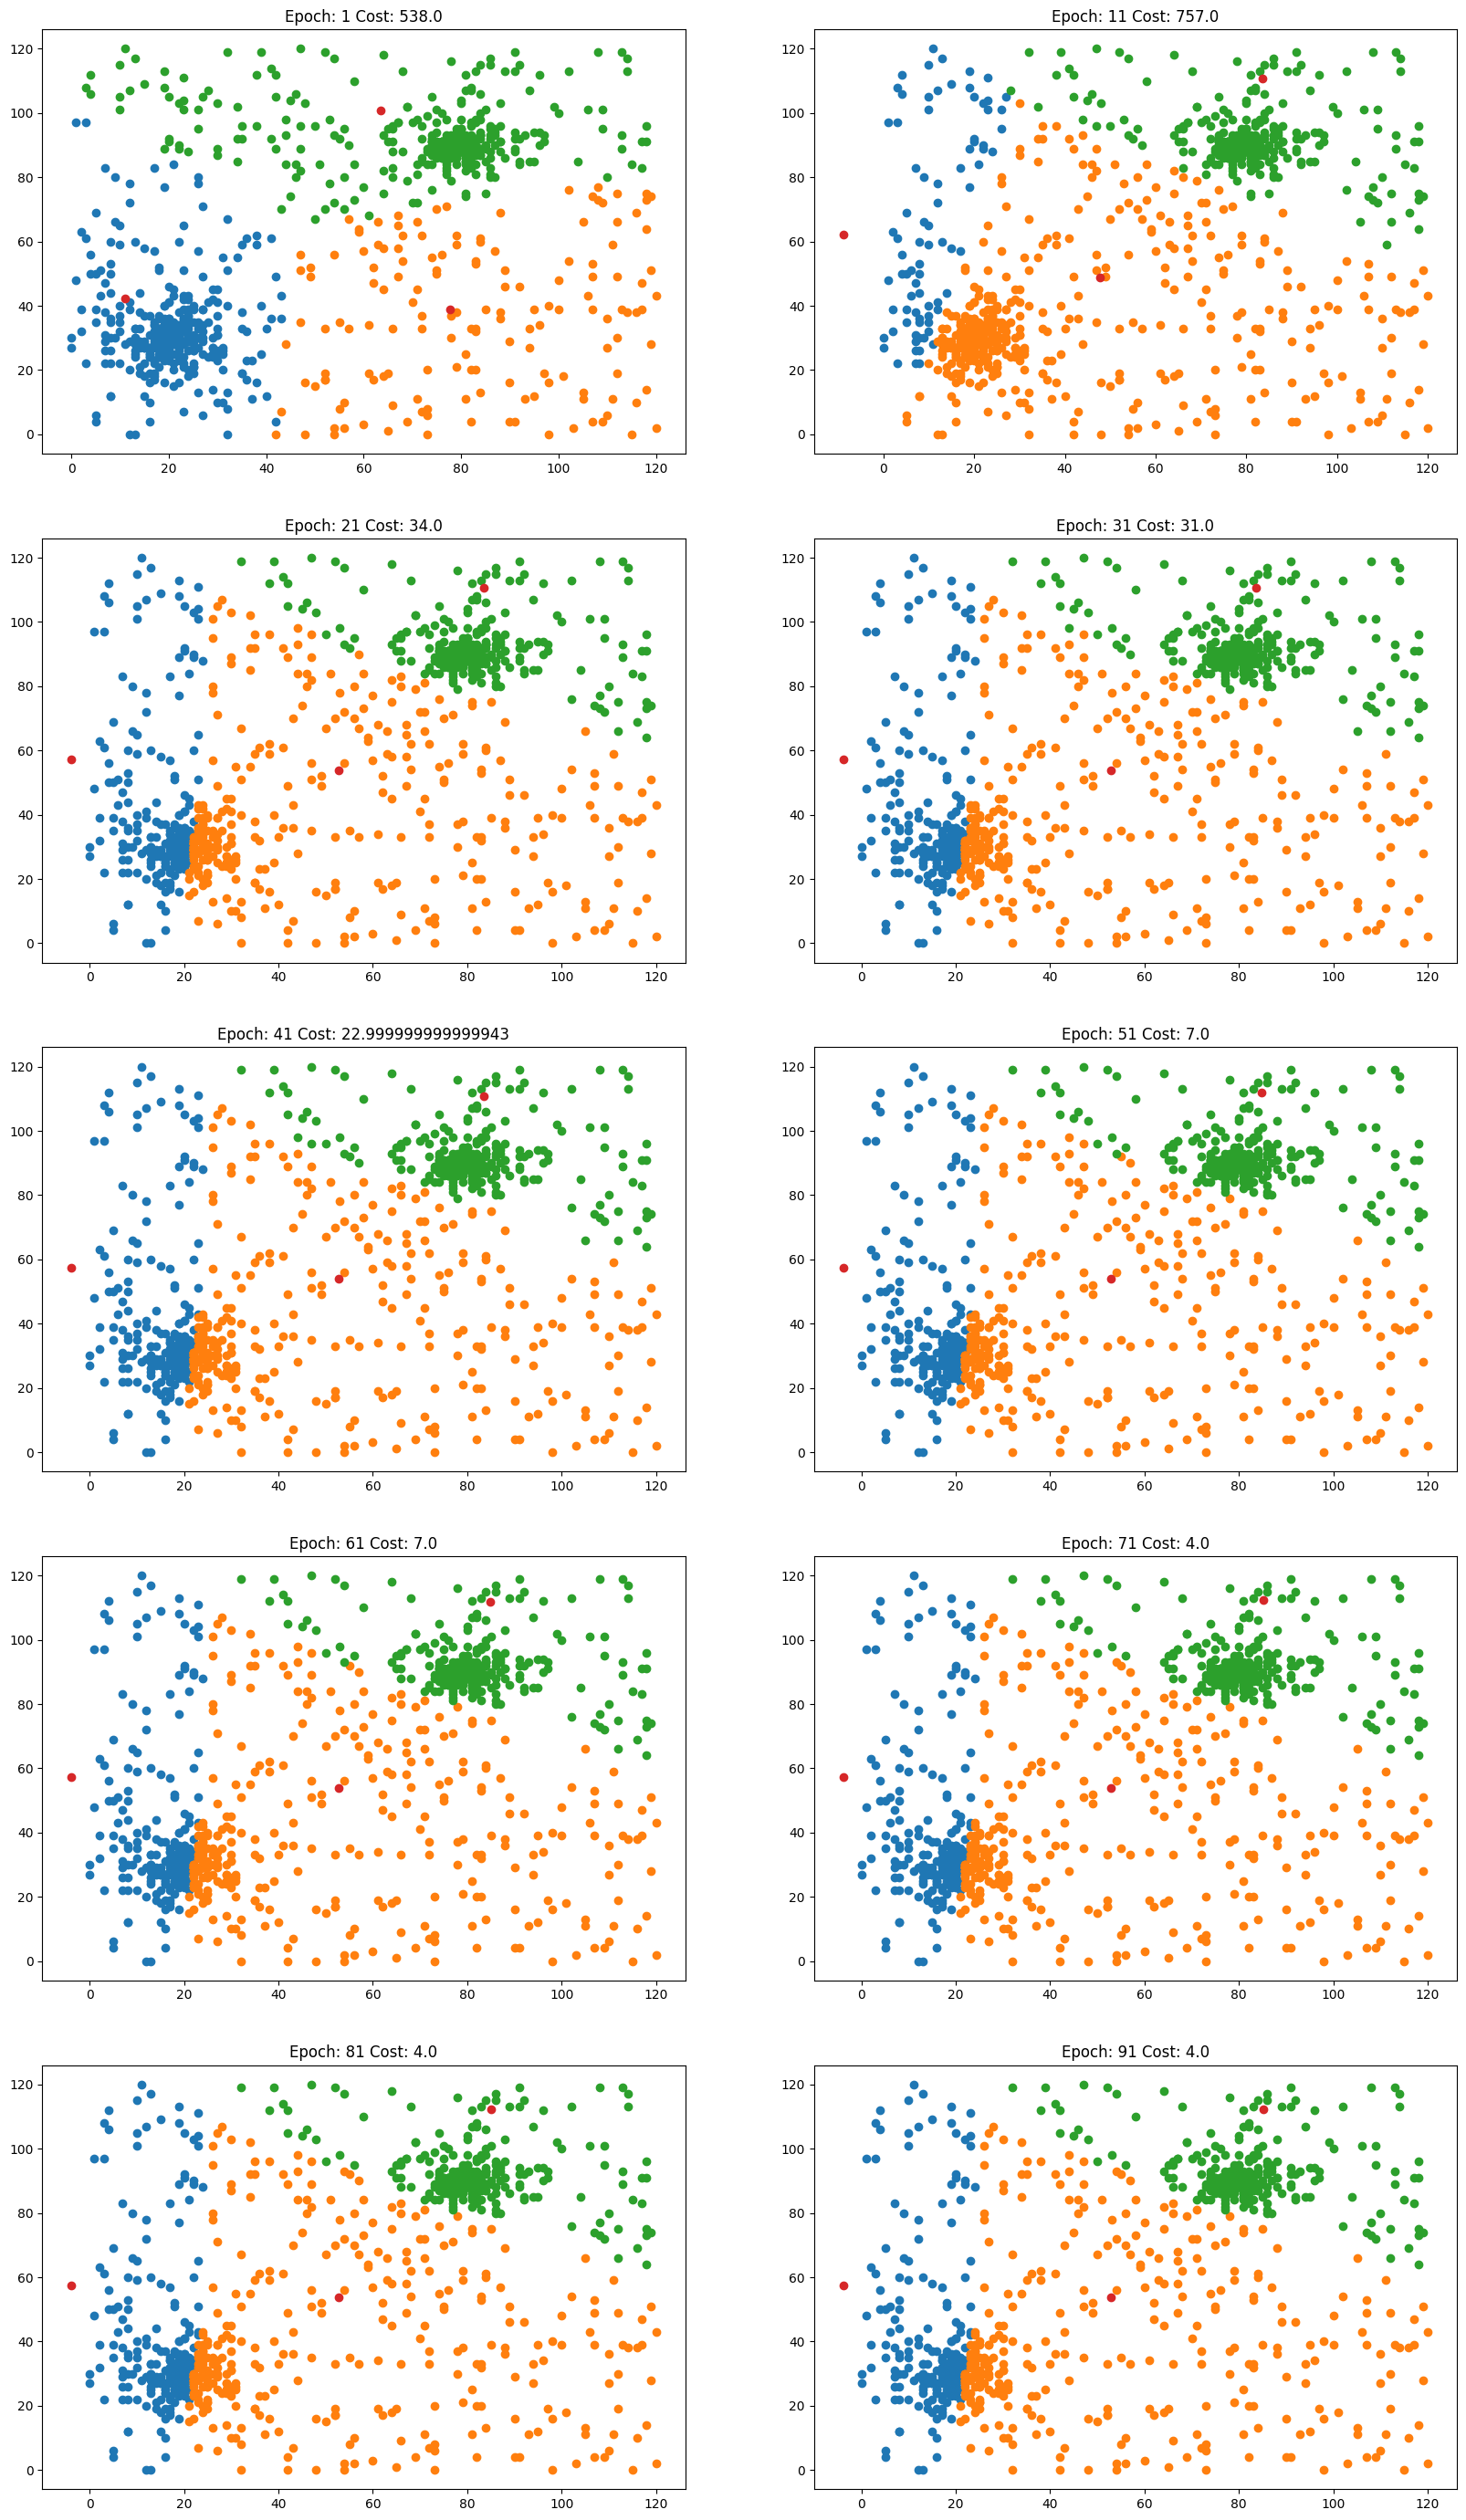

In [52]:
from IPython.display import display, clear_output

cost = []
districts = 3
epochs = 100

perfectPop = populationMap.shape[0] / districts 

learnRate = 10 #how agressive the model changes itself
lastMin = 0 #determines when we make learnRate smaller

fig, ax = plt.subplots(5,2,figsize = (20,35))#setting up for later visualization
order = [[0,0],[0,1],[1,0],[1,1],[2,0],[2,1],[3,0],[3,1],[4,0],[4,1],[5,0],[5,1]]

#adds weights to our node map
districtNodes = districtMap
districtNodes["weights"] = [1] * districtMap.shape[0]
districtNodes["weights"] = districtNodes["weights"].astype('float64')


for i in range(epochs):
    ownership = reComputePop(populationMap,districtNodes)
    currCost = findCost(ownership,perfectPop)

    #additionsDistrict is a DataFrame that stores the additions to be made to the curretn model.
    additionsDistrict = pd.DataFrame(columns = ["X","Y","weights"])
    additionsDistrict["weights"] = additionsDistrict["weights"].astype('float64')

    #this for loop will go through all weights (X,Y,weights) to test which direction to move all of them.
    for e in districtNodes.iterrows():
        currRow = {"X":0,"Y":0,"weights":0}
        #X change
        copyDistrictNodes = districtNodes.copy(deep = True)
        copyDistrictNodes.loc[e[0],"X"] = copyDistrictNodes.loc[e[0],"X"] - learnRate #gets the cost when "X" is lowered
        ownership = reComputePop(populationMap,copyDistrictNodes)
        minusCost = findCost(ownership,perfectPop)
        copyDistrictNodes = districtNodes.copy(deep = True)
        copyDistrictNodes.loc[e[0],"X"] = copyDistrictNodes.loc[e[0],"X"] + learnRate#gets the cost when "X" is added to
        ownership = reComputePop(populationMap,copyDistrictNodes)
        plusCost = findCost(ownership,perfectPop)

        #checks which addition yields the lowest cost
        if min([currCost,minusCost,plusCost]) == currCost:
            currRow["X"] = 0
        elif min([currCost,minusCost,plusCost]) == plusCost:
            currRow["X"] = learnRate
        elif min([currCost,minusCost,plusCost]) == minusCost:
            currRow["X"] = -learnRate

        #Y change
        copyDistrictNodes = districtNodes.copy(deep = True)
        copyDistrictNodes.loc[e[0],"Y"] = copyDistrictNodes.loc[e[0],"Y"] - learnRate #gets the cost when "Y" is lowered
        ownership = reComputePop(populationMap,copyDistrictNodes)
        minusCost = findCost(ownership,perfectPop)

        copyDistrictNodes = districtNodes.copy(deep = True)
        copyDistrictNodes.loc[e[0],"Y"] = copyDistrictNodes.loc[e[0],"Y"] + learnRate #gets the cost when "Y" is added to
        ownership = reComputePop(populationMap,copyDistrictNodes)
        plusCost = findCost(ownership,perfectPop)
        #checks which addition yields the lowest cost
        if min([currCost,minusCost,plusCost]) == currCost:
            currRow["Y"] = 0
        elif min([currCost,minusCost,plusCost]) == plusCost:
            currRow["Y"] = learnRate
        elif min([currCost,minusCost,plusCost]) == minusCost:
            currRow["Y"] = -learnRate


        #weights change (since weights is a scale from 0 to 1 and on, the weights need to be changed slower.)
        
        copyDistrictNodes = districtNodes.copy(deep = True)
        copyDistrictNodes.loc[e[0],"weights"] = copyDistrictNodes.loc[e[0],"weights"] - (.05 * (learnRate / 10)) #gets the cost when "weights" is lowered
        ownership = reComputePop(populationMap,copyDistrictNodes)
        minusCost = findCost(ownership,perfectPop)
        copyDistrictNodes = districtNodes.copy(deep = True)
        copyDistrictNodes.loc[e[0],"weights"] = copyDistrictNodes.loc[e[0],"weights"] + (.05 * (learnRate / 10)) #gets the cost if "weights" is added to
        ownership = reComputePop(populationMap,copyDistrictNodes)
        plusCost = findCost(ownership,perfectPop)
        #checks which addition yields the lowest cost
        if min([currCost,minusCost,plusCost]) == currCost:
            currRow["weights"] = currRow["weights"]
        elif min([currCost,minusCost,plusCost]) == plusCost:
            currRow["weights"] = currRow["weights"] + (.05 * (learnRate / 40))
        elif min([currCost,minusCost,plusCost]) == minusCost:
            currRow["weights"] = currRow["weights"] - (.05 * (learnRate / 40))
        
        additionsDistrict.loc[len(additionsDistrict)] = currRow #this process is done for every district, so the additionsDistrict holds a row for each.
        
    for e in districtNodes.iterrows():#adds the changes the additionsDictrict DataFrame held to the current state
        districtNodes.loc[e[0],"X"] = districtNodes.loc[e[0],"X"] + additionsDistrict["X"][e[0]]
        districtNodes.loc[e[0],"Y"] = districtNodes.loc[e[0],"Y"] + additionsDistrict["Y"][e[0]]
        districtNodes.loc[e[0],"weights"] = districtNodes.loc[e[0],"weights"] + additionsDistrict["weights"][e[0]]
    ownership = reComputePop(populationMap,districtNodes)
    currCost = findCost(ownership,perfectPop)
    clear_output(wait=True)
    
    if len(cost) > 1 and min(cost) <= currCost:#if no improvements have been made in cost for the last 10 epochs, learn rate is lowered
        lastMin +=1
        if lastMin > 10:
            lastMin = 0
            learnRate /= 2
    else:
        lastMin = 0
        
    cost.append(currCost)#stores cost for later visualization

    #this process takes the longest out of any other part of the project, sometimes days, so the code below is a status report that updates eveyr epoch.
    print("Epoch:" + str(i + 1))
    print("Learn Rate: " + str(learnRate))
    print("Position and Weights:")
    print(districtNodes)
    print("\nCurrent Cost: " + str(currCost) + "\n")
    for x,e in enumerate(ownership):
        err = round(((e.shape[0] - optimalPopulation)/optimalPopulation) * 10000)/100
        print("District " + str(x+1) + ": " + str(e.shape[0]) + "K people, with an error of: " + str(err) + "%")
    if i % 10 == 0:
        currentGraph = (order[(i+1)//10][0],order[(i+1)//10][1])
        for e in ownership:
            ax[currentGraph].scatter(data = e,x = "X",y = "Y")
        ax[currentGraph].scatter(data= districtNodes,x= "X",y = "Y")
        ax[currentGraph].set_title("Epoch: " + str((i + 1)) + " Cost: " + str(currCost))

Remember, Gradient Descent moves the points **very slowly** in a direction and uses the Cost function to see if its making any **progress.**
<br><br>

---

### Results:

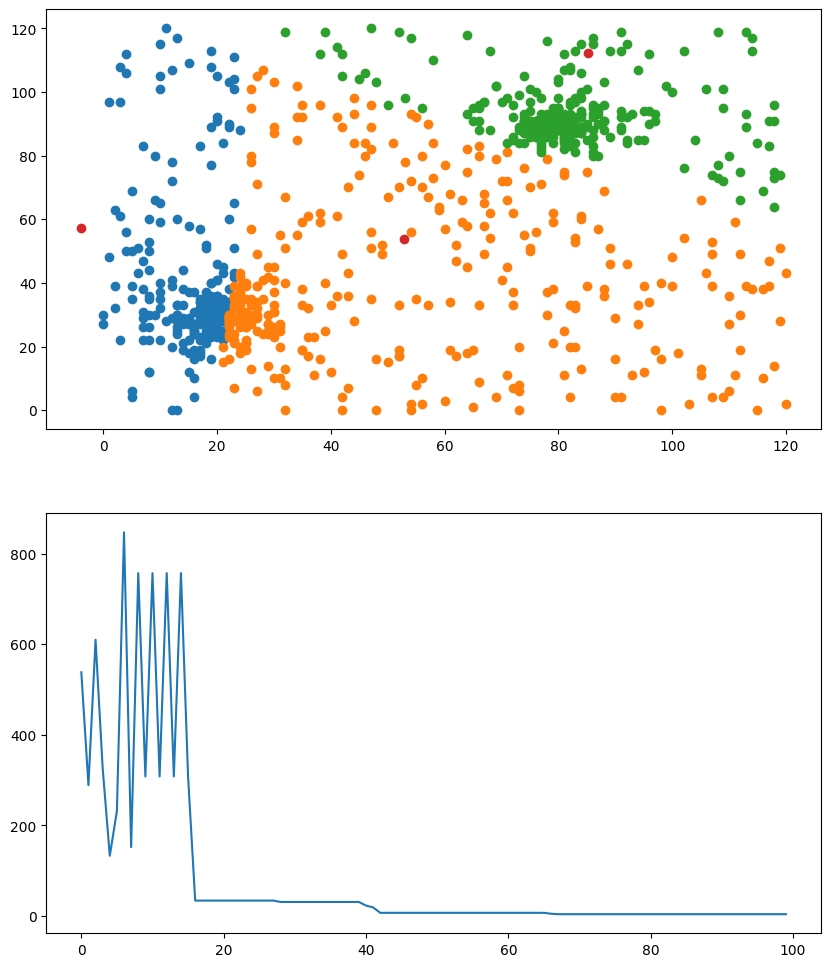

In [53]:
fig1,ax1 = plt.subplots(2,figsize = (10,12))
for e in ownership:
    ax1[0].scatter(data = e,x = "X",y = "Y")
ax1[0].scatter(data= districtNodes,x= "X",y = "Y")
ax1[1].plot(list(range(0,len(cost))),cost)

#### What's going on?
1. The top graph is the map of the **final districts**.  The colors do not mean anything, they are there to show which districts own what population points.

2. The bottom graph is a **cost graph**.  It shows the error of the model over time.  You typically want the cost to start at a high number then work it's way down. <br>

**It's okay if the graph goes back and forth. This means it has hit the bottom for the current learn rate and needs the learn rate to be smaller to get rid of more cost.**

---

Let's calculate error:

In [54]:
print("Final district Population:")
for x,i in enumerate(ownership):
    err = round(((i.shape[0] - optimalPopulation)/optimalPopulation) * 10000)/100
    print("District " + str(x+1) + ": " + str(i.shape[0]) + "K people, with an error of: " + str(err) + "%")
print("\nThe optimal population for each district is: " + str(optimalPopulation))

Final district Population:
District 1: 332K people, with an error of: -0.3%
District 2: 334K people, with an error of: 0.3%
District 3: 334K people, with an error of: 0.3%

The optimal population for each district is: 333


Now our Congressional Districts are on par, or even better than real life districts.  We got this model to work, now let's do some real life examples.

(Remember, the real-life district error is 1.9%)

---

#### Final Districts:

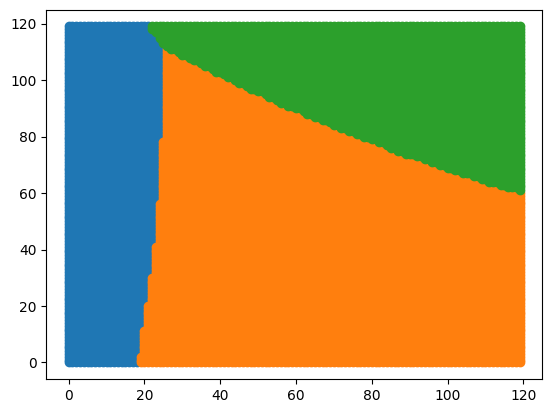

In [55]:
totalShape = pd.DataFrame(columns = ("X","Y"))
for i in range(120):
    for e in range(120):
        totalShape.loc[len(totalShape)] = [i,e]
ownership = reComputePop(totalShape,districtNodes)
for i in ownership:
    plt.scatter(data= i, x = "X",y = "Y")
        

This is a map of the districts, and how much territory they own.

# State Redistricting

#### Here's how we will be redistricting states:

1. Pull a picture of the state off the internet

2. Turn it into a DataFrame and get all the pixels that aren't white and store their coordinates in a DataFrame

3. Use city locations and populations to get a good population map

4. Save the DataFrame

©bonilla1879 / Adobe Stock


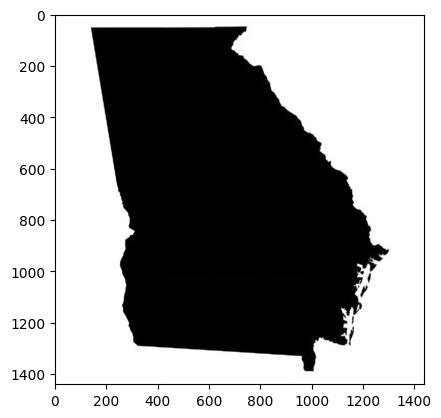

In [56]:
#Get the picture
print("©bonilla1879 / Adobe Stock")

import matplotlib.pyplot as plt
from PIL import Image
pic = Image.open("/kaggle/input/state-shapes/georgia.jpg")
plt.imshow(pic)

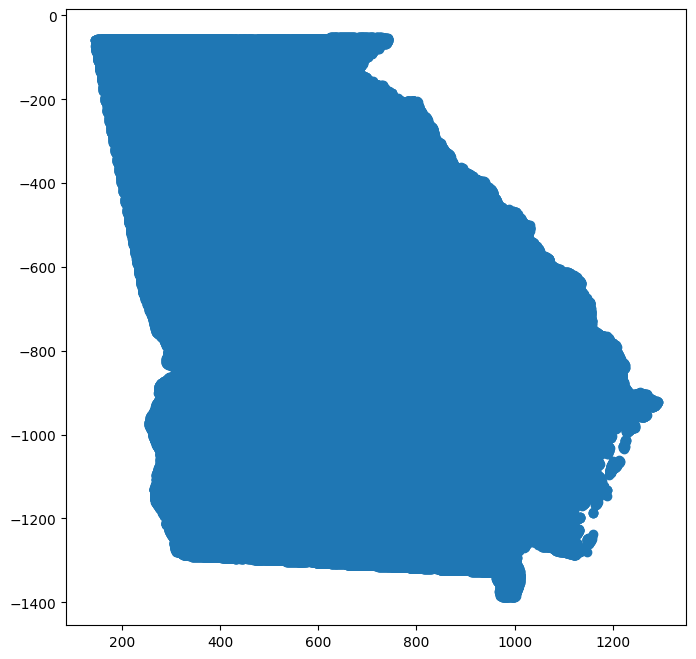

In [57]:
pic = np.array(pic,np.float32)

#goes through the whole image and turns every pixel that is dark enough to straight [0,0,0]
for x,i in enumerate(pic):
    for w,e in enumerate(i):
        if sum(list(e)) < 20:
            pic[x][w] = np.array([0,0,0])
x = []
y = []

#then it adds the black pixels to a DataFrame
for iCount,i in enumerate(pic):
    for eCount,e in enumerate(i):
        if sum(e) == 0:
            x.append(eCount)
            y.append(-iCount)
ylim = min(y)
for i in y:
    i += -ylim

total = pd.DataFrame()
total["X"] = x
total["Y"] = y
plt.figure(figsize = (8,8))
plt.scatter(data = total,x = "X",y = "Y")

This is the shape of Georgia. We will be using it to make sure our population model matches the borders and shape of Georgia.

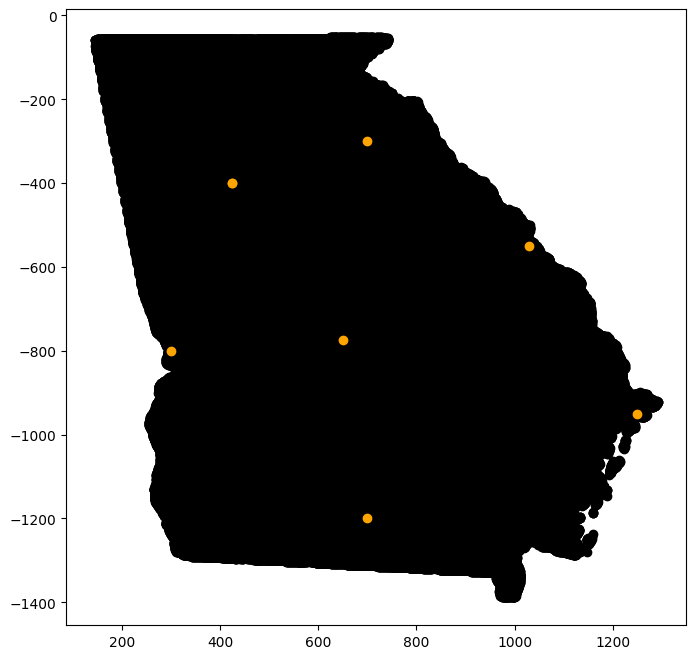

In [58]:
cities = pd.DataFrame(columns = ("X","Y","population","radius","Name"))
citiesLoc = [#location of the cities
    (425,-400,520,3,"Atlanta"),
    (1250,-950,148,13,"Savannah"),
    (1030,-550,202,20,"Augusta"),
    (700,-300,128,14.5,"Athens"),
    (650,-775,157,9.5,"Macon"),
    (700,-1200,56,7,"Valdosta"),
    (300,-800,202,20,"Columbus"),
    (425,-400,5880,40,"Atlanta Greater Area")
    ]
for i in citiesLoc:#turns the above lists into a DataFrame
    cities.loc[len(cities)] = i
    
otherpopulation = 3887
x = []
y = []
for i in citiesLoc:
    x.append(i[0])
    y.append(i[1])
cities["X"] = x
cities["Y"] = y

plt.figure(figsize = (8,8))
plt.scatter(data = total,x = "X",y = "Y",color = "black")
plt.scatter(data = cities,x= "X",y = "Y",color= "orange")

What's going on?

These dots are the center of cities across Georgia. The population spread will be made from them.<br>
There are two points in Atlanta, one for the population that lives **in Atlanta** and one for the population that lives in the **Greater Atlanta Area**.

In [59]:
def generateRural(orgX,orgY,maxDis,stateWidth,modelWidth):#alike the generateCitizen, but to prioritize further population
    """
    Generates population for rural areas
    
    input: 
    orgX: x value of the rural position
    orgY: y value of the rural position
    maxDis: size of the rural area (typically the whole state)
    stateWidth: width of the state in real life
    modelWidth: width of the model made
    """
    accepted = False
    maxDis = maxDis / stateWidth
    maxDis = maxDis * modelWidth
    while accepted == False:
        dis = random.uniform(-maxDis,maxDis)
        direction = math.radians(random.randint(0,360))
        xTemp = orgX + math.cos(direction) * dis
        yTemp = orgY + math.sin(direction) * dis
        cond = total["X"] == round(xTemp)
        cond2 = total["Y"] == round(yTemp)
        if (cond & cond2).any() and dis > 100:
            accepted = True
    return (round(xTemp),round(yTemp))
def generateCitizen(orgX,orgY,maxDis,stateWidth,modelWidth):
    """
    Generates population for cities
    
    input: 
    orgX: x value of the city
    orgY: y value of the city
    maxDis: size of the city
    stateWidth: width of the state in real life
    modelWidth: width of the model made
    """
    accepted = False
    maxDis = maxDis / stateWidth
    maxDis = maxDis * modelWidth
    while accepted == False:
        #Generating Randomly generated point (Inside the given city)
        dis = random.uniform(-maxDis,maxDis)
        perOfDis = random.uniform(0,1)
        dis = dis * perOfDis
        direction = math.radians(random.randint(0,360))
        xTemp = orgX + math.cos(direction) * dis
        yTemp = orgY + math.sin(direction) * dis

        #Checks if the generated point is in the boundaries of the state.
        cond = total["X"] == round(xTemp)
        cond2 = total["Y"] == round(yTemp)
        if (cond & cond2).any():
            accepted = True
    return (round(xTemp),round(yTemp))

In [60]:
x = []
y = []

stateWidth = 230 #width of georgia, according to google maps
totalWidth = max(total["X"]) - min(total["X"])#width of our model
for i in cities.iterrows():
    for e in range(int(i[1]["population"])):#Generates citizens, based on real life cities, and rural areas.
        res = generateCitizen(i[1]["X"],i[1]["Y"],i[1]["radius"],stateWidth,totalWidth)
        #add the values to the lists
        x.append(res[0])
        y.append(res[1])
    print(str(i[1]["Name"] + " Generated."))

for i in range(otherpopulation): 
    temp = generateRural(425,-400,375,stateWidth,totalWidth)
    x.append(temp[0])
    y.append(temp[1])
print("Rural Population Generated.")


Atlanta Generated.
Savannah Generated.
Augusta Generated.
Athens Generated.
Macon Generated.
Valdosta Generated.
Columbus Generated.
Atlanta Greater Area Generated.
Rural Population Generated.


Estimated Population Distribution / Training Model


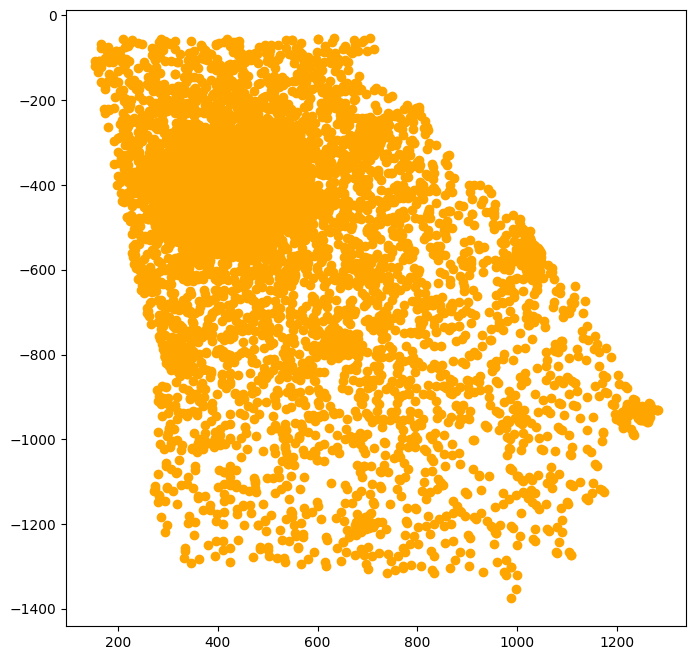

In [61]:
plt.figure(figsize=(8, 8))
plt.scatter(x= x,y = y,color= "orange")
print("Estimated Population Distribution / Training Model")

#### Results:

Georiga has **11.18 million** people, and **14 congressional districts**. The training of this model took 33 hours to run.

(-0.5, 1456.5, 1469.5, -0.5)

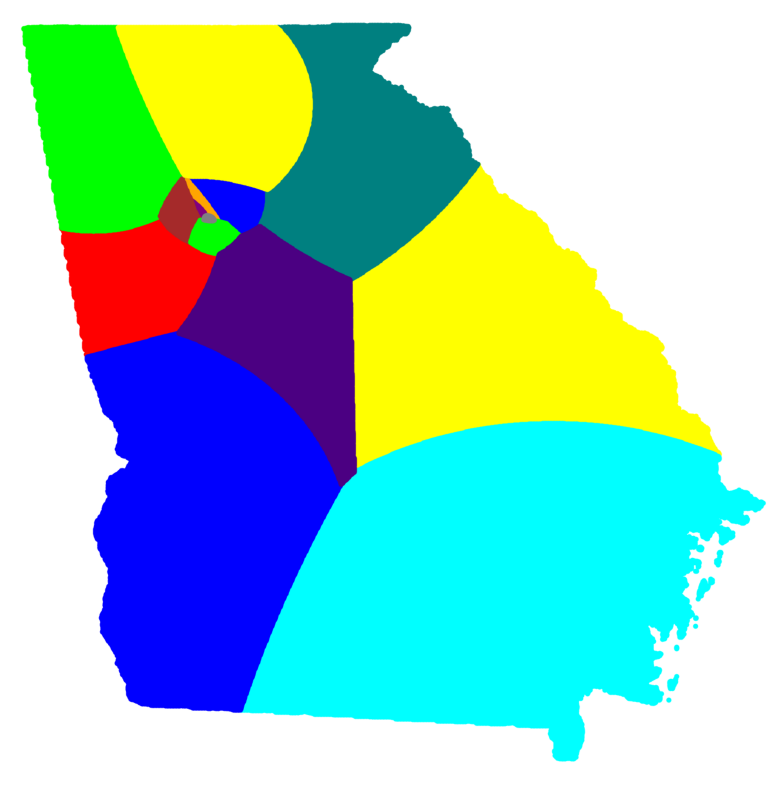

In [62]:
pic = Image.open("/kaggle/input/finalresultsstates/finalgeorgiaDistricts3.png")
fig,ax = plt.subplots(1,1,figsize = (10,10))
ax.imshow(pic)
ax.axis("off")

#### Georgia Post-Redictricting Data

Final Cost: **13.71**<br>(For context, cost starts at tens of thousands, and over hours works its way down.)<br>
Final District Populations:<br>
District 1: 799K<br>District 2: 798K<br>District 3: 798K<br>District 4: 799K<br>District 5: 798K<br>District 6: 799K<br>District 7: 801K<br>District 8: 798K<br>District 9: 798K<br>District 10: 798K<br>District 11: 798K<br>District 12: 798K<br>District 13: 799K<br>District 14: 799K<br><br>
Optimal District Population: 798.57K<br>
Total Runtime: 33.2 Hours<br>
Model Photo credit:  ©bonilla1879 / Adobe Stock<br>
Population Deviation per District:

In [63]:
print("% error of population per district:\n")
districtPops = [799,798,798,799,798,799,801,798,798,798,798,798,799,799]#district populations
perfectPopulation = 798.57
for x,i in enumerate(districtPops):#Gets standard percent error
    err = round((perfectPopulation - i)/perfectPopulation * 1000000) / 10000
    print("District " + str(x+1) + ": " + str(err) + "%")

% error of population per district:

District 1: -0.0538%
District 2: 0.0714%
District 3: 0.0714%
District 4: -0.0538%
District 5: 0.0714%
District 6: -0.0538%
District 7: -0.3043%
District 8: 0.0714%
District 9: 0.0714%
District 10: 0.0714%
District 11: 0.0714%
District 12: 0.0714%
District 13: -0.0538%
District 14: -0.0538%


Not only are these districts tigher in population than real world districts, but they are also better in shape.  

#### Side by side comparison:

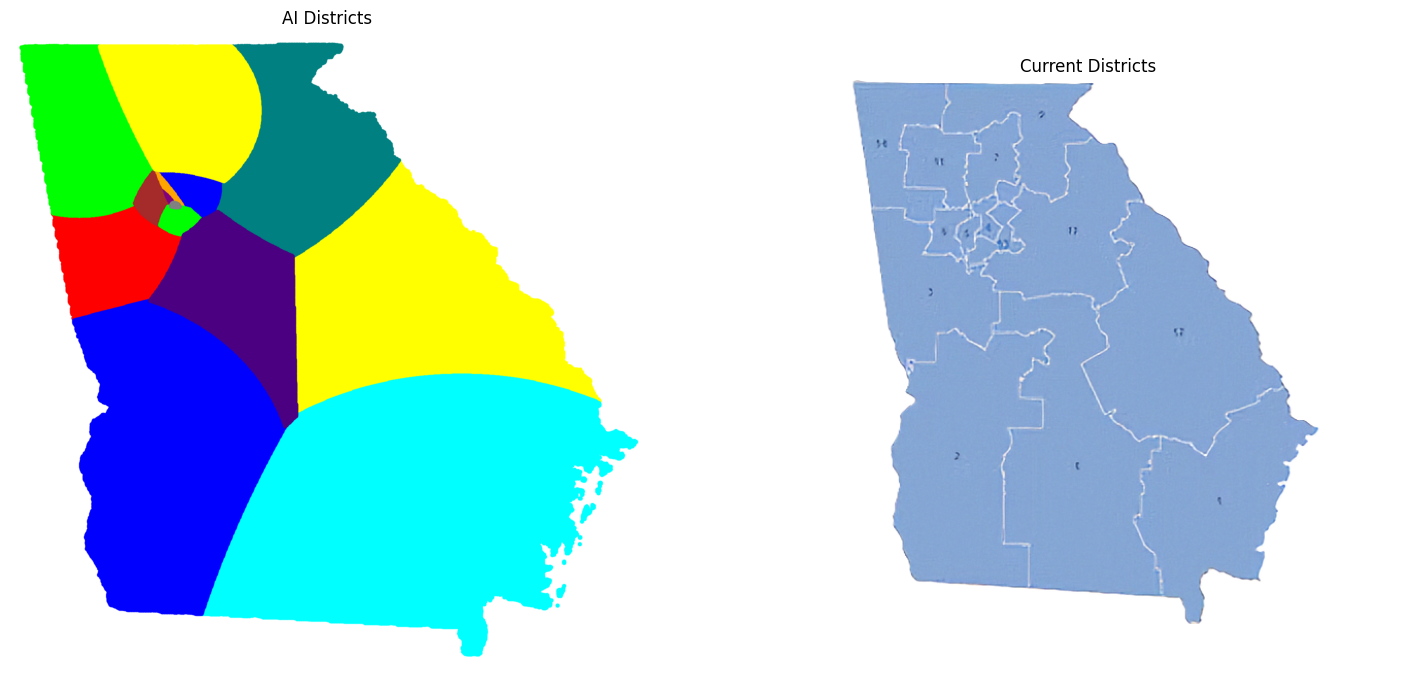

In [64]:
fig, ax = plt.subplots(1,2,figsize = (18,10))
genDistricts = Image.open("/kaggle/input/finalresultsstates/finalgeorgiaDistricts3.png")
realDistricts = Image.open("/kaggle/input/finalresultsstates/realGeorgiaDistrictsCensus.png")
ax[0].imshow(genDistricts)
ax[0].set_title("AI Districts")
ax[0].axis("off")
ax[1].imshow(realDistricts)
ax[1].set_title("Current Districts")
ax[1].axis("off")
print("")

#### Possible Limitations:

The population in south georgia was likely underrepresented, due to model distortion.<br>
The north Atlanta District is thin and long, looking a little gerrymandered.

# Louisiana

(-0.5, 1458.5, 1465.5, -0.5)

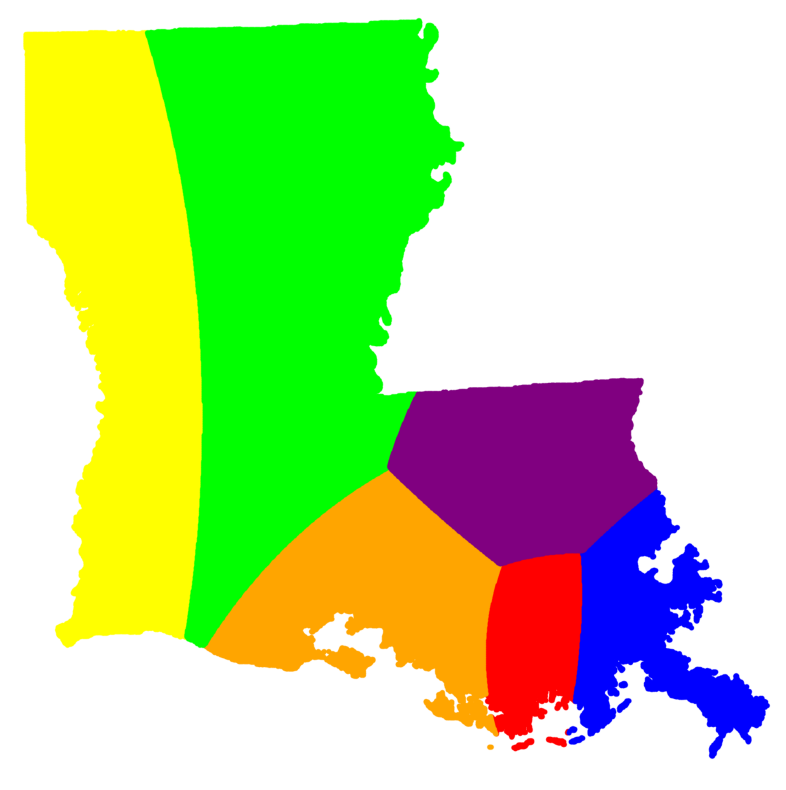

In [65]:
pic = Image.open("/kaggle/input/finalresultsstates/finalLouisianaDistricts.png")
fig,ax = plt.subplots(1,1,figsize = (15,10))
ax.imshow(pic)
ax.axis("off")

#### Louisiana Post-Redictricting Data

Final Cost: **6.0**<br>
Final District Populations:<br>
District 1: 767K<br>District 2: 766K<br>District 3: 767K<br>District 4: 767K<br>District 5: 765K<br>District 6: 766K<br><br>
Optimal District Population: 766.3333333333334K<br>
Total Runtime: 13 Hours<br>
Model Photo credit:  ©bonilla1879 / Adobe Stock<br>
Population Deviation per Dictrict:<br>

In [66]:
print("% error of population per district:\n")
districtPops = [1159,1157,1159,1159,1159,1158]#district populations
perfectPopulation = 1158.5
for x,i in enumerate(districtPops):#Gets standard percent error
    err = round((perfectPopulation - i)/perfectPopulation * 1000000) / 10000
    print("District " + str(x+1) + ": " + str(err) + "%")

% error of population per district:

District 1: -0.0432%
District 2: 0.1295%
District 3: -0.0432%
District 4: -0.0432%
District 5: -0.0432%
District 6: 0.0432%


#### Side by side comparison:

(-0.5, 615.5, 527.5, -0.5)

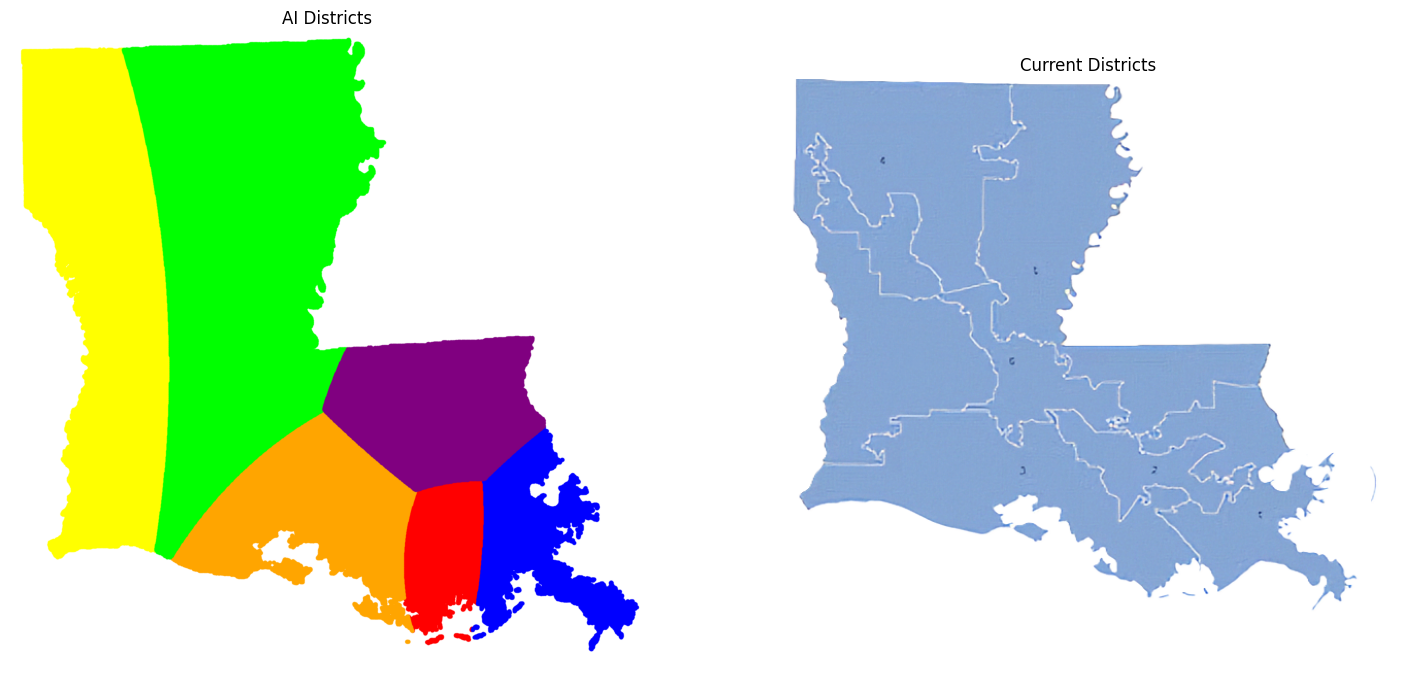

In [67]:
fig, ax = plt.subplots(1,2,figsize = (18,10))
genDistricts = Image.open("/kaggle/input/finalresultsstates/finalLouisianaDistricts.png")
realDistricts = Image.open("/kaggle/input/finalresultsstates/realLousisianaDistrictsCensus.png")
ax[0].imshow(genDistricts)
ax[0].set_title("AI Districts")
ax[0].axis("off")
ax[1].imshow(realDistricts)
ax[1].set_title("Current Districts")
ax[1].axis("off")

#### Possible Limitations:

Model Distortion
(Looking at the current map, you can see that louisiana is visibly heavily gerrymandered, so the competion is not real tough here.)<br>
Northern Districts look a little too big, possible due to rural model distortion.

# Illinois

(-0.5, 1083.5, 1485.5, -0.5)

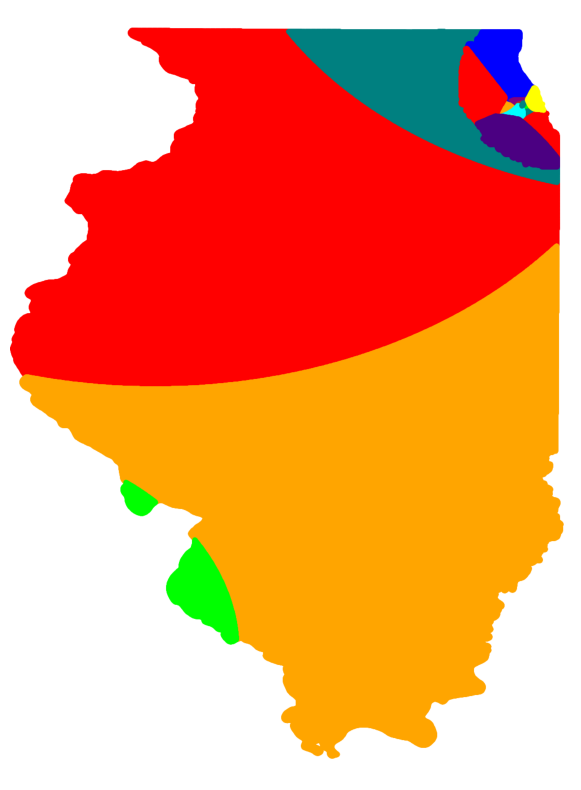

In [68]:
pic = Image.open("/kaggle/input/finalresultsstates/finalIllinoisDistricts.png")
fig,ax = plt.subplots(1,1,figsize = (15,10))
ax.imshow(pic)
ax.axis("off")

#### Illinois Post-Redictricting Data

Final Cost: **214.0**<br>
Final District Populations:<br>
District 1: 687K<br>District 2: 698K<br>District 3: 688K<br>District 4: 699K<br>District 5: 696K<br>District 6: 698K<br>District 7: 684K<br>District 8: 698K<br>District 9: 693K<br>District 10: 691K<br>District 11: 696K<br>District 12: 686K<br>District 13: 691K<br>District 14: 695K<br>District 15: 698K<br>District 16: 693K<br>District 17: 695K<br><br>
Optimal District Population: 693.0<br>
Total Runtime: 1 Week<br>
Model Photo credit:  ©bonilla1879 / Adobe Stock<br>
Population Deviation per Dictrict:<br>

In [69]:
print("% error of population per district:\n")
districtPops = [687,698,688,699,696,698,684,698,693,693,691,696,686,691,695,693,695]#district populations
perfectPopulation = 693
for x,i in enumerate(districtPops):#Gets standard percent error
    err = round((perfectPopulation - i)/perfectPopulation * 1000000) / 10000
    print("District " + str(x+1) + ": " + str(err) + "%")

% error of population per district:

District 1: 0.8658%
District 2: -0.7215%
District 3: 0.7215%
District 4: -0.8658%
District 5: -0.4329%
District 6: -0.7215%
District 7: 1.2987%
District 8: -0.7215%
District 9: 0.0%
District 10: 0.0%
District 11: 0.2886%
District 12: -0.4329%
District 13: 1.0101%
District 14: 0.2886%
District 15: -0.2886%
District 16: 0.0%
District 17: -0.2886%


#### Side by side comparison:

(-0.5, 999.5, 1689.5, -0.5)

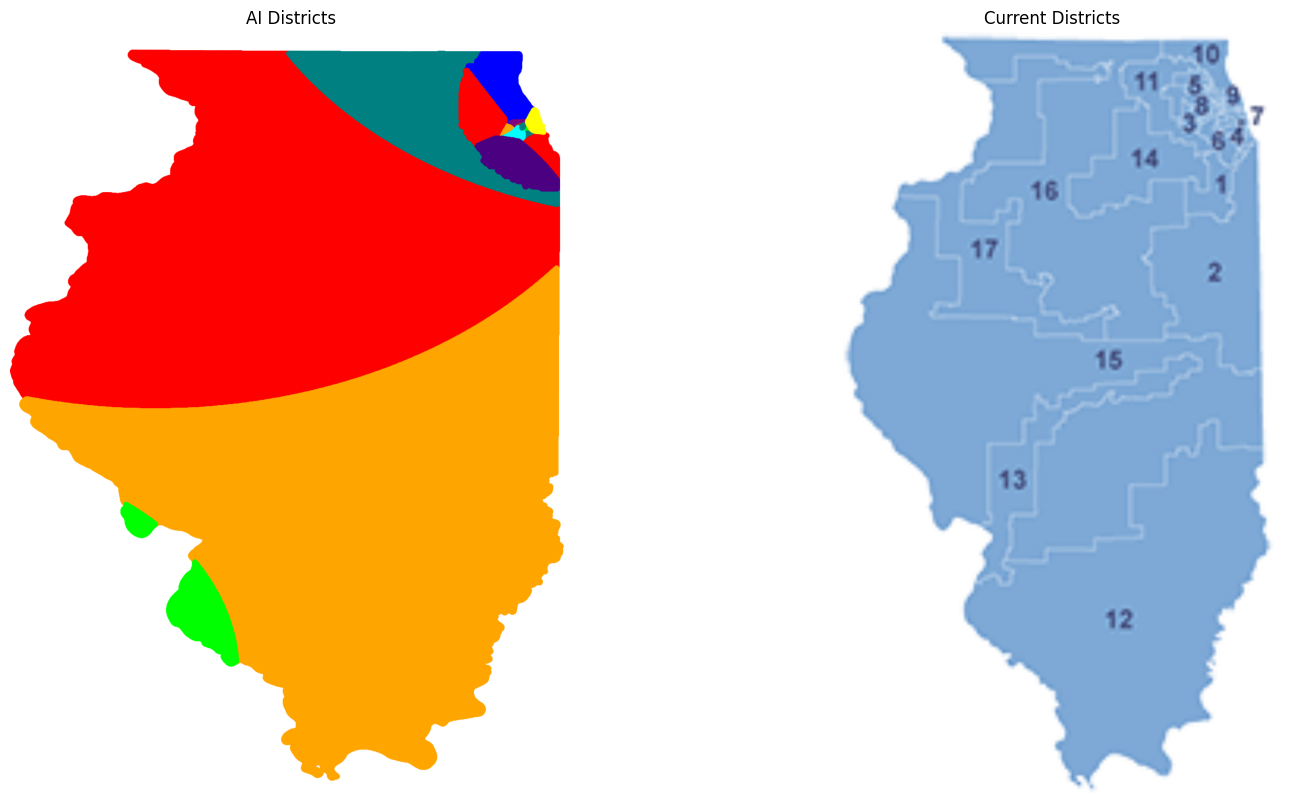

In [70]:
fig, ax = plt.subplots(1,2,figsize = (18,10))
genDistricts = Image.open("/kaggle/input/finalresultsstates/finalIllinoisDistricts.png")
realDistricts = Image.open("/kaggle/input/finalresultsstates/realIllinoisDistricts.png")
ax[0].imshow(genDistricts)
ax[0].set_title("AI Districts")
ax[0].axis("off")
ax[1].imshow(realDistricts)
ax[1].set_title("Current Districts")
ax[1].axis("off")

#### Here's a close up on Chicago:

In [ ]:
fig, ax = plt.subplots(1,2,figsize = (18,10))
genDistricts = Image.open("/kaggle/input/finalresultsstates/finalIllinoisDistrictsCloseUp.png")
realDistricts = Image.open("/kaggle/input/finalresultsstates/realIllinoisDistrictsCloseUp.png")
ax[0].imshow(genDistricts)
ax[0].set_title("AI Districts")
ax[0].axis("off")
ax[1].imshow(realDistricts)
ax[1].set_title("Current Districts")
ax[1].axis("off")

(-0.5, 799.5, 790.5, -0.5)

#### Possible Limitations:


Model Distortion - It's possible chicago was given too much population, and not enough population for the rural areas.

Different Setup - I ran into an issue redistricting this state, because Chicago has an incredible population. It was putting strain on the weights, so the model ran into many local minimums and other dead ends.  I resorted to splitting up chicago from the rest of the state after four days of straight training.  I believe if this model is improved both on efficiency and quality, this will not be an issue, and the model will be able to redistrict Illinois easily.  

Irregularly Shaped District - As a result of this new method, the south Chicago district looks a little gerrymandered, because it covers the city borders. 


---

#### Next Steps:

There are a couple changes that can be made to make this redistricting model better.

1. Multi Factor Cost Function<br>
The Cost Function we have right now only takes one metric in consideration; population.  In other more complicated models this is not the case.  By adding a way to measure shape and density of the population in a district, we can yield districts with better shapes.  

2. Better Population Distribution Models<br>
The model making method that I used while creating a map of the states for the AI to run on was crudely made.  I can use government or private API's to get better and more accurate population distribution, yielding more accurate districts.

3. Better use of AI API's<br>
While limiting the use of AI libraries and API's show the concepts better, these tools often are faster than running all the math yourself, because they both organize the data better, and run the machine in parallel, making efficient use of the CPU or GPU.  If this model gets fast enough, there may be no need to make models that are 1000 people per data point, it may be 100, 10 or even one dot per person.

<br>

---

#### Limitations of this method:

This model has rules that it needs to follow, being a node based system. Because gerrymandering is a big issue, there are ways to judge a congressional district that this method does not address, and some of them the model fails. Here they are:

1. Minority Vote:  When districting a state, politicians will give the minoity vote a little more voice, when districting.  This model does not address this factor because it does not know the concept of race, ethnicity, or policical ideology.
2. Geographic borders:  If the state is irregularily shaped, this model will likely respond to it, but in real life redistricting, borders are drawn with certain geographic features in mind, like mountains, bodies of water, and even deserts.  This model does respond to it, seeing the population distribution, but not as much as a real politician would.
3. District borders: Some redistricters feel it is important to draw districts along the country lines. Because the model does not know these districts, it does not draw a single district along county lines.  With that said, it is possible to make another model that takes the population and shape of these county lines, and uses gradient descent to assign counties to districts. It would likely be faster than this model, but it would not yield the population proximity that this model did.

I am aware of these short comings. However, solving some of these issues require information on the beliefs of the people, and taking this information to draw the borders. This, to me, could be considered as a form of gerrymandering itself.  I believe the best way to redistrict boundaries is to draw the borders with an unbaised eye, with no knowledge of who votes for what, and that is exactly what this model does.


#### Credits:

All congressional district photos are taken from census.gov.<br>
U.S. Census Bureau. My Congressional District. n.d. U.S. Census Bureau, https://www.census.gov/mycd/
. Accessed 14 Sept. 2025.<br>
Close up of Chicago is from:<br>
“Illinois’s Congressional Districts.” Wikipedia, The Free Encyclopedia, 12 Sept. 2025, en.wikipedia.org/wiki/Illinois%27s_congressional_districts. Accessed 28 Sept. 2025.

Georgia: 
©bonilla1879 / Adobe Stock<br>
Louisiana:
©bonilla1879 / Adobe Stock<br>
Illinois:
©bonilla1879 / Adobe Stock


---

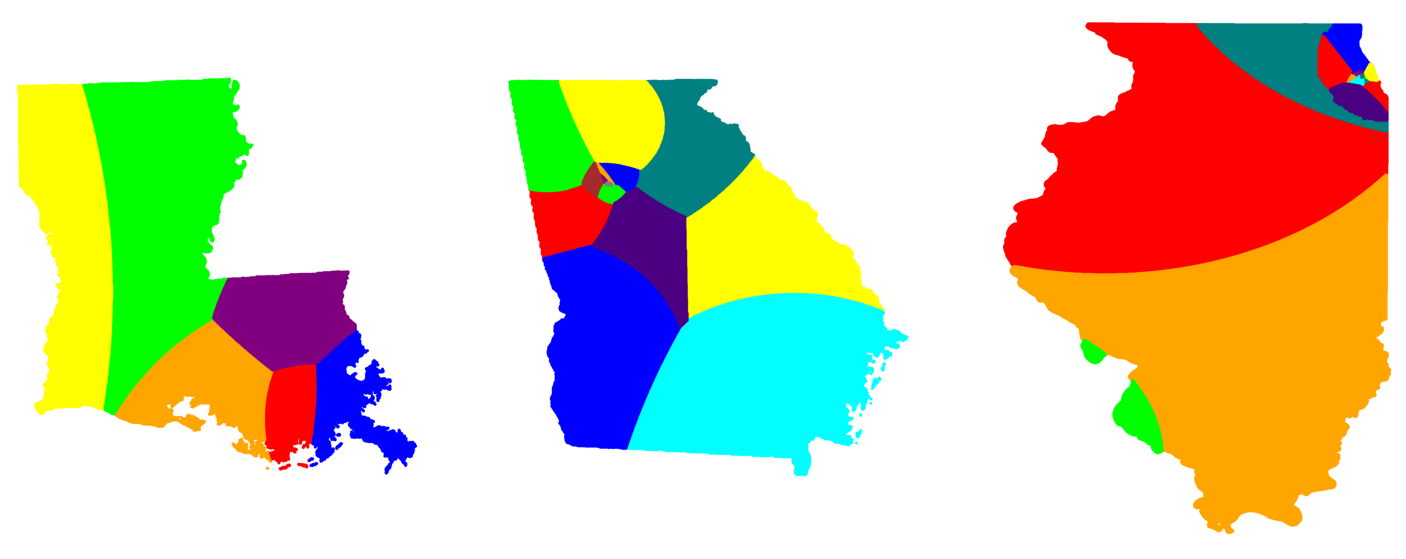

In [ ]:
fig, ax = plt.subplots(1,3,figsize = (18,7))
louisianaDistricts = Image.open("/kaggle/input/finalresultsstates/finalLouisianaDistricts.png")
georgiaDistricts = Image.open("/kaggle/input/finalresultsstates/finalgeorgiaDistricts3.png")
illinoisDistricts = Image.open("/kaggle/input/finalresultsstates/finalIllinoisDistricts.png")
ax[0].imshow(louisianaDistricts)
ax[0].axis("off")
ax[1].imshow(georgiaDistricts)
ax[1].axis("off")
ax[2].imshow(illinoisDistricts)
ax[2].axis("off")

### Thank You for Listening!

©John Ziolo